In [1]:
import numpy as np
from qiskit.circuit.library                   import RYGate,RZGate,RXGate,IGate,UGate,NLocal,TwoLocal,RealAmplitudes,XGate,HGate, RXXGate, RYYGate, RZZGate
from qiskit.circuit                           import Parameter
from qiskit.aqua.components.optimizers        import L_BFGS_B,COBYLA,CG,ADAM,SPSA,AQGD
from qiskit.aqua.components.initial_states    import *
from qiskit.aqua.algorithms                   import VQE
from qiskit.aqua                              import QuantumInstance,aqua_globals

from qiskit                                   import IBMQ
from qiskit.providers.aer.backends.aerbackend import AerBackend
from qiskit.providers.ibmq.ibmqbackend        import IBMQBackend
from qiskit.providers.aer                     import noise
from qiskit.providers.aer.noise               import NoiseModel
from qiskit.ignis.mitigation.measurement      import (complete_meas_cal,CompleteMeasFitter)
import logging
from qiskit.aqua                              import set_qiskit_aqua_logging
#set_qiskit_aqua_logging(logging.DEBUG) 

from   qiskit                                 import *
from   qiskit.quantum_info                    import Pauli,Operator
from   qiskit.aqua.operators                  import SummedOp,PauliOp,CircuitStateFn,WeightedPauliOperator, StateFn, PauliExpectation, CircuitSampler,AerPauliExpectation
from   qiskit.aqua.operators.primitive_ops    import MatrixOp
from   qiskit.aqua.operators.legacy           import MatrixOperator,op_converter
from   qiskit.aqua.algorithms                 import NumPyEigensolver,NumPyMinimumEigensolver
from   qiskit.compiler                        import transpile, assemble
from qiskit.aqua.operators                    import X, Y, Z, I
from qiskit.aqua.operators.gradients          import Gradient
from qiskit.converters                        import circuit_to_gate
from qiskit.tools.monitor                     import job_monitor


import math
from math                                     import isclose
import matplotlib 
import matplotlib.pyplot as plt
from IPython.display                          import display, Markdown
import itertools

from scipy                                    import linalg as LA
from scipy.optimize                           import curve_fit
import functools
import time

# Tomography functions
from qiskit.ignis.verification.tomography     import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography     import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography     import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement    as mc
import qiskit.ignis.mitigation                as mit

from qiskit.providers.aer.noise.errors.standard_errors import thermal_relaxation_error
from qiskit.providers.aer.noise                        import NoiseModel
from qiskit.ignis.characterization.coherence           import T1Fitter, T2StarFitter, T2Fitter
from qiskit.ignis.characterization.coherence           import t1_circuits, t2_circuits, t2star_circuits


In [2]:
def generate_pauli(idx_x,idx_z,n):
    '''
    Args:
       n   (integer)
       idx (List)
    Returns:
       tensor product of Pauli operators acting on qubits in idx
       Y = iZX
       P0 P1 P2 P3 P4
       Pi = (X)^a (Z)^b
    '''
    xmask = [0]*n
    zmask = [0]*n
    for i in idx_x: xmask[i] = 1
    for i in idx_z: zmask[i] = 1
    a_x = np.asarray(xmask,dtype=np.bool)
    a_z = np.asarray(zmask,dtype=np.bool)
    return Pauli(a_z,a_x)

#The following function is used to define the operators that appear in the Heisenberg hamiltonian above
#In PauliOp the default coefficient is 1.0
def generate_Heisenberg(nqubit,nn_list):
    pauli_list = []
    for (i,j) in nn_list:
        xixj = PauliOp(generate_pauli([i,j],[],nqubit));    pauli_list.append(xixj)
        yiyj = PauliOp(generate_pauli([i,j],[i,j],nqubit)); pauli_list.append(yiyj)
        zizj = PauliOp(generate_pauli([],[i,j],nqubit));    pauli_list.append(zizj)
    H = SummedOp(pauli_list)
    return H

#Here we define the spin operators acting on site i
#We note that this function returns the name of the operator (site+component) and its value
def generate_spin_operators(nqubit):
    spins = []
    for i in range(nqubit):
        xi = generate_pauli([i],[],nqubit);  spins.append( (str(i)+'x',PauliOp(xi,1.0)) )
        yi = generate_pauli([i],[i],nqubit); spins.append( (str(i)+'y',PauliOp(yi,1.0)) )
        zi = generate_pauli([],[i],nqubit);  spins.append( (str(i)+'z',PauliOp(zi,1.0)) )
    return spins

#We note that the argument aux_operators will be the output of function generate_spin_operators
def diagonalize_H(H,aux_operators):
    '''
    k = number of eigenvalues/eigenvectors to find
    H |ci) = Ei |ci)
    Ai = (ci|A|ci)
    aux_ops: list of length k; each element is an array of shape (nprops,2) for real and imaginary part
    '''
    ee = NumPyEigensolver(operator=H,k=2**H.num_qubits,aux_operators=[s for name_s,s in aux_operators])
    ee = ee.run()
    energies = np.real(ee['eigenvalues'])
    psi = ee['eigenstates']
    aux_ops = ee['aux_operator_eigenvalues']
    
    '''
    for i,(ei,ai) in enumerate(zip(energies,aux_ops)):
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        for js,(name_s,s) in enumerate(aux_operators):
            print("     Spin ",name_s,round(ai[js][0],6))  #ai[js] has two arguments: the real and imaginary parts
        print("Eigenvector:")
        psi_i = psi[i].primitive.to_dict()
        for k in psi_i.keys():
            print("     ",k,psi_i[k])
    '''
    return energies,psi,aux_ops

def generate_spinspin_operators(nqubit):
    spin_spin=[]
    for i in range(nqubit):
        for j in range(nqubit):
            xi = PauliOp(generate_pauli([i],[],nqubit));
            xj = PauliOp(generate_pauli([j],[],nqubit));
            
            yi = PauliOp(generate_pauli([i],[i],nqubit));
            yj = PauliOp(generate_pauli([j],[j],nqubit));
            
            zi = PauliOp(generate_pauli([],[i],nqubit));
            zj = PauliOp(generate_pauli([],[j],nqubit));
            
            spin_spin.append( (str(i)+'x-'+str(j)+'x',xi.compose(xj)))
            spin_spin.append( (str(i)+'y-'+str(j)+'y',yi.compose(yj)) )
            spin_spin.append( (str(i)+'z-'+str(j)+'z',zi.compose(zj)) )
            
    return spin_spin

def to_ket(psi):
    """ Write a statevector in braket notation.
    Parameters
    ----------
    ψ: ndarray
        the statevector
    Returns
    -------
    ket: str
        the statevector in braket notation
    """
    # GET WIDTH OF EACH STATE LABEL
    n = int(np.ceil(np.log2(len(psi))))
    # CONSTRUCT STRING ONE STATE AT A TIME
    ket = ""
    for i, c in enumerate(psi):
        # PREPARE STATE LABEL
        label = np.binary_repr(i,n)     # CONVERT INDEX TO CORRESPONDING LABEL
        label = label[::-1]             # (OPTIONAL) USE ALTERNATE INDEXING
        # UPDATE ket STRING
        if np.round(c,3)!=0.:
            if i > 0: ket += " + "
            ket += f"({c:.3f}) |{label}⟩"   # (OPTIONAL) FIX COEFFICIENT'S PRECISION
    return ket

def to_state(psi):
    # GET WIDTH OF EACH STATE LABEL
    n = int(np.ceil(np.log2(len(psi))))
    #state = np.zeros(len(psi),dtype=np.complex_)
    state=np.zeros(len(psi),dtype=float)
    for i, c in enumerate(psi):
        # PREPARE STATE LABEL
        label = np.binary_repr(i,n)     # CONVERT INDEX TO CORRESPONDING LABEL
        label = label[::-1]             # (OPTIONAL) USE ALTERNATE INDEXING

        v=[np.zeros(2,dtype=float) for i in range(n)]
        for k in range(n):
            v[k][int(label[k])]=1.
                    
        #print(label,v)
        val=np.kron(v[0],v[1])
        for j in range(2,n):
            val=np.kron(val,v[j])
        val=np.dot(c,val)
        state+=val
    return state


#### Functions to define exact total spin eigenstates

In [3]:
def sign(x):
    if(x>0): 
        return  1
    else:    
        return -1

def convert(x):
    return int(round(np.abs(2*x)))

def get_clebsch(j1,m1,j2,m2,J,M):
    from sympy.physics.quantum.cg import CG
    # S is the shortcut for sympify and converts an arbitrary expression to a type that can be used inside SymPy
    sgnJ  = sign(J) 
    from sympy import S     
    sgnM  = sign(M)
    sgnj1 = sign(j1)
    sgnm1 = sign(m1)
    sgnj2 = sign(j2)
    sgnm2 = sign(m2)
    numJ  = convert(J)
    numM  = convert(M)
    numj1 = convert(j1)
    numm1 = convert(m1)
    numj2 = convert(j2)
    numm2 = convert(m2)
    cg = CG(sgnj1*S(numj1)/2,sgnm1*S(numm1)/2,sgnj2*S(numj2)/2,sgnm2*S(numm2)/2,sgnJ*S(numJ)/2,sgnM*S(numM)/2)
    return float(cg.doit().evalf())

# ------------------------------------------------------

# Remark - It's important to notice that the vector associated with psi_JM is a matrix, therefore the indexes we print in the following function are the
#          matrix indexes on which we have a non-zero value. By this way the indexes can be read also as up or down spin vectors.
#          E.g. (0,1,1) --> (up,down,down)

def print_states(psi_dict):
    for k in psi_dict.keys():
        print("State ",k)
        n = len(psi_dict[k].shape)
        for idx in itertools.product([0,1],repeat=n):
            c = psi_dict[k][idx]
            # If we don't insert the following "if", we would see all the null contributes to the state |J,M>
            if(not isclose(c,0.0,abs_tol=1e-4)):
                print(idx," ",c)
        print(" ")
            
# Given the z-component of spin, m, the following function returns the vectors (1 0)^T (j=1/2, m=1/2) or (0 1)^T (j=1/2, m=-1/2)
def one_spin_states(j,m):
    # isclose returns True if two values are closer than the abs_tol
    if(isclose(m,0.5,abs_tol=1e-4)):        
        i=0
    else:                            
        i=1
    psi    = np.zeros(2)
    psi[i] = 1.0
    return psi[:]

def compose_two_spins(label=''):
    psi = {}
    j1,j2 = 1.0/2.0,1.0/2.0
    for J in [0,1]:
        for M in range(-J,J+1):
            psi_JM = np.zeros((2,2))
            for x1 in [0,1]:
                for x2 in [0,1]:
                    m1,m2 = (x1-j1),(x2-j2)
                    cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                    psi_JM += cg*np.einsum('a,b->ab',one_spin_states(j1,m1),one_spin_states(j2,m2))
            #print(psi_JM)
            psi[label+'_'+str(J)+'_'+str(M)] = psi_JM
    return psi

def compose_with_center(psi_left,label=''):
    psi = {}
    j2 = 1.0/2.0
    for j1 in [0,1]:
        for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
            for M in np.arange(-J,J+1e-4,1.0):
                psi_JM_j1 = np.zeros((2,2,2))
                for x1 in range(2*j1+1):
                    for x2 in [0,1]:
                        m1,m2 = (x1-j1),(x2-j2)
                        cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                        psi_JM_j1 += cg*np.einsum('ab,c->abc',psi_left[label+'_'+str(j1)+'_'+str(m1)],one_spin_states(j2,m2))
                psi[label+'_j1_'+str(j1)+'_lc_'+str(J)+'_'+str(M)] = psi_JM_j1
    return psi

def compose_with_right(psi_lc,psi_r):
    psi={}
    lc_list=[]

    for k in psi_lc.keys():
        klc = k.split('_')
        lab_lc=klc[0]
        jL = float(klc[2])
        j1 = float(klc[4])
        if((jL,j1) not in lc_list):
            lc_list.append((jL,j1))

    for k in psi_r.keys():
        kr=k.split("_")
        lab_r=kr[0]
        break

    for el in lc_list:
        jL=int(el[0])
        j1=el[1]
        #print(jL, " ", j1)
        for j2 in [0,1]:
            for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
                #print(" ",J)
                for M in np.arange(-J,J+1e-4,1.0):
                    # Label with spin left jL, spin right jR and spin left + center jLC 
                    lab = 'jL_'+str(jL)+'_jR_'+str(j2)+'_jLC_'+str(j1)+'_LCR_'+str(J)+'_'+str(M)
                    psi[lab] = np.zeros((2,2,2,2,2))
                    for m1 in np.arange(-j1,j1+1e-4,1):
                        for m2 in np.arange(-j2,j2+1e-4,1):
                            lab1=lab_lc+'_j1_'+str(jL)+'_lc_'+str(j1)+'_'+str(m1)
                            lab2=lab_r+'_'+str(j2)+'_'+str(int(m2))
                            cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                            psi[lab] += cg*np.einsum('abc,de->abcde',psi_lc[lab1],psi_r[lab2])
    return psi

#### Measure operator 

Here we define the new function `measure_operator` which returns the mean value and the variance of a given `SummedOp` operator. We remind that in the case in which we use a `statevector_simulator` we will have variance equal to $0$ because the expression is evaluated using linear algebra calculations. 

In [4]:
def measure_operator(O,circ,instance):
    # Definition of operator O (SummedOp !!), state ket and <ket|O|ket>
    ket=CircuitStateFn(circ)
    op=StateFn(O,is_measurement=True)
    braket=op@ket

    # Convert to expectation value
    grouped = PauliExpectation().convert(braket)  

    # Get state sampler (you can also pass the backend directly)
    sampled_op = CircuitSampler(instance).convert(grouped)
    
    # Get mean value and variance
    mean_value=sampled_op.eval().real
    variance = PauliExpectation().compute_variance(sampled_op).real
    return mean_value,variance

#### Measure operator on hardware

**Remarks**

- The `evaluate_with_result` method of `WeightedPauliOperator` returns the mean value and the standard deviation, instead of the variance.

- If `measure` is initialized with a list of circuits, the function returns a list of mean values and standard deviation.

In [5]:
def measure(op,circ,instance):
    # Conversion from SummedOp to WeightedPauliOperator
    operator = op_converter.to_weighted_pauli_operator(MatrixOperator(op.to_matrix()))
    
    circuit  = operator.construct_evaluation_circuit(wave_function               = circ,
                                                     statevector_mode            = instance.is_statevector,
                                                     use_simulator_snapshot_mode = False,
                                                     circuit_name_prefix         = 'EvalCircuit')
    print("Job pending",end=" ")
    result = instance.execute(circuit)
    print("Job completed")
    
    mean,std = operator.evaluate_with_result(result                      = result,
                                             statevector_mode            = instance.is_statevector,
                                             use_simulator_snapshot_mode = False,
                                             circuit_name_prefix         = 'EvalCircuit')
    mean,std = np.real(mean),np.abs(std)
    return mean,std

#### Definition of spin operators: $\hat{S}_x$, $\hat{S}_y$, $\hat{S}_z$, $\hat{S}^2$

In [6]:
op_s022 = (1.5*I^I^I) + (0.5*X^I^X) + (0.5*Y^I^Y) + (0.5*Z^I^Z) 
op_sl2  = (1.5*I^I^I) + (0.5*I^X^X) + (0.5*I^Y^Y) + (0.5*I^Z^Z) 
op_sx   = (0.5*I^I^X) + (0.5*I^X^I) + (0.5*X^I^I)
op_sy   = (0.5*I^I^Y) + (0.5*I^Y^I) + (0.5*Y^I^I)
op_sz   = (0.5*I^I^Z) + (0.5*I^Z^I) + (0.5*Z^I^I)
op_s2   = (op_sx@op_sx + op_sy@op_sy + op_sz@op_sz).to_pauli_op()

# The $3$-spin Clebsch-Gordan quantum circuits 

In [7]:
nqubits = 3
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]
shot_list=[100,200,500,1000,2000,4000,8000]

IBMQ.load_account()                                                  # connettersi a IBMQ
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device   = provider.get_backend('ibmq_athens')                        # 5 qubit, lineare, buono
#device   = provider.get_backend('ibmq_5_yorktown')                   # 5 qubit, papillon, medio
#device   = provider.get_backend('ibmq_16_melbourne')                 # 16 qubit, "ladder", cattivo
backend  = Aer.get_backend('qasm_simulator') 

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## All the CG circuits 

We consider the $8$ circuits by building them one by one. We use the shape of circuit **B**.

### Histograms of expectation values on hardware with error mitigation and Richardson extrapolation

This method works with the use of error mitigation given as input of the `QuantumInstance`. In this part we also consider the best optimization level and layout before running the measurement operations.

We remind the following abbreviations:

- **EM** = *Error Mitigation*
- **RE** = *Richardson Extrapolation*

#### Alternative readout error mitigation procedure

As alternative we could work with the use of `complete_meas_cal`. Look at: https://qiskit.org/textbook/ch-applications/hhl_tutorial.html#B.-Running-HHL-on-a-real-quantum-device:-optimised-example.

In this case as `measure` **returns a list of mean and standard deviation values**, we have to evaluate the total mean value and the total standard deviation. The list of circuits given as input inside `measure` are the calibration circuits of error mitigation, therefore we will have the **total mean value by averaging over the single mean values** and the **total stardard deviation by taking the square root of the sum of all variances**, which in turn are square of single standard deviation.

####  Definition of: standard deviation for extrapolated value at $N_{CNOT} =0$ and straight line

In [8]:
def extr_dev_std(x,sigma):
    s   = 0
    sx  = 0
    sx2 = 0
    for i in range(len(x)):
        sx  += x[i]
        sx2 += x[i]**2
    delta = len(x)*sx2 - sx**2
    
    for j,xj in enumerate(x):
        s += (sx2**2 + -2*xj*sx*sx2 + (sx**2)*(xj**2))*(sigma[j]**2)
    return np.sqrt(s/(delta**2))

def straight_line(x,m,q):
    return m*x+q

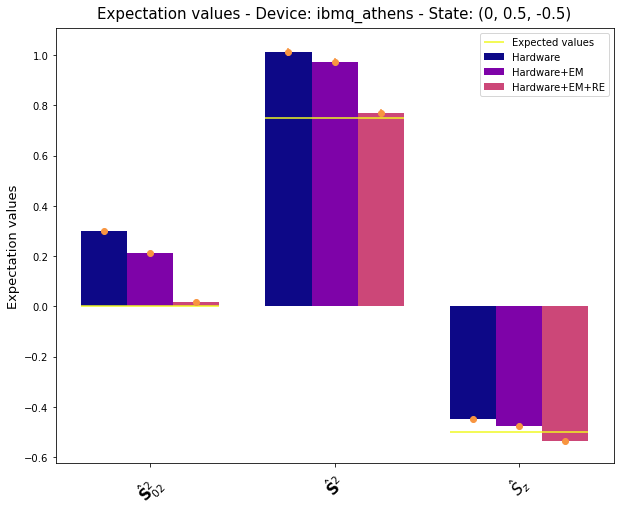

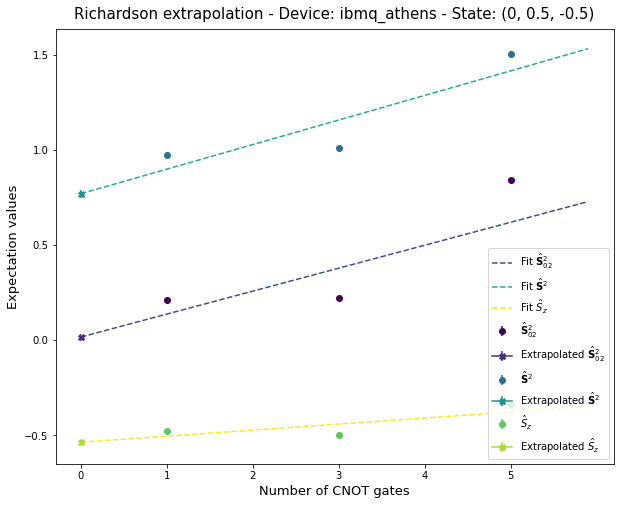

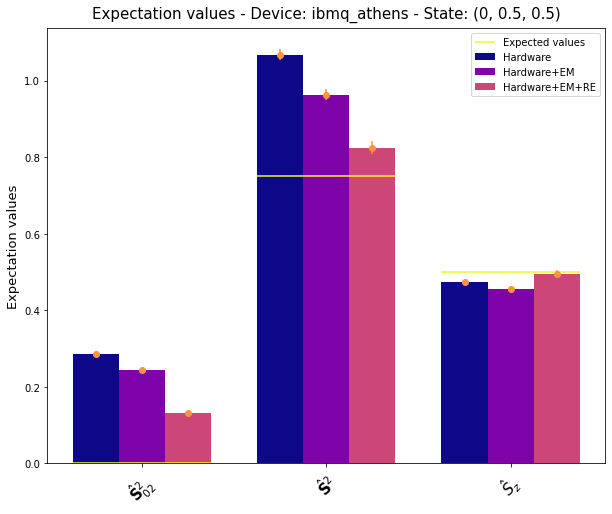

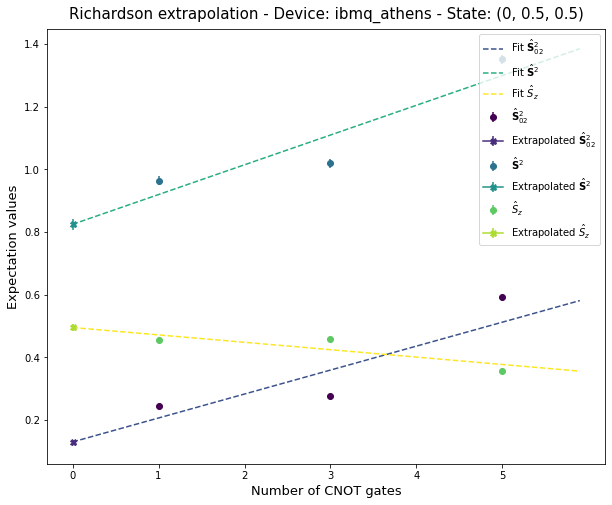

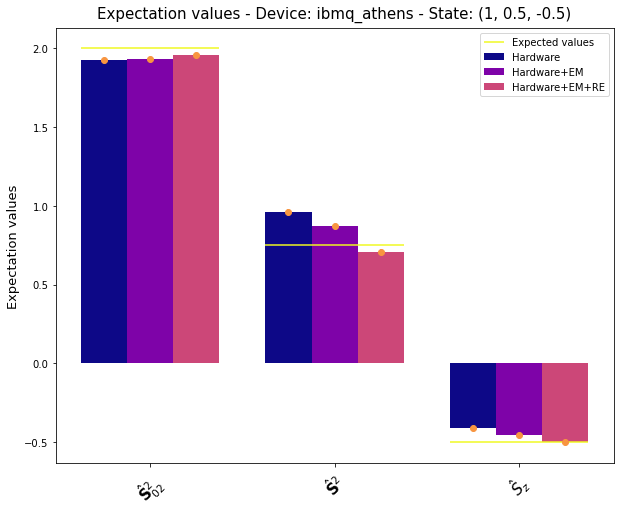

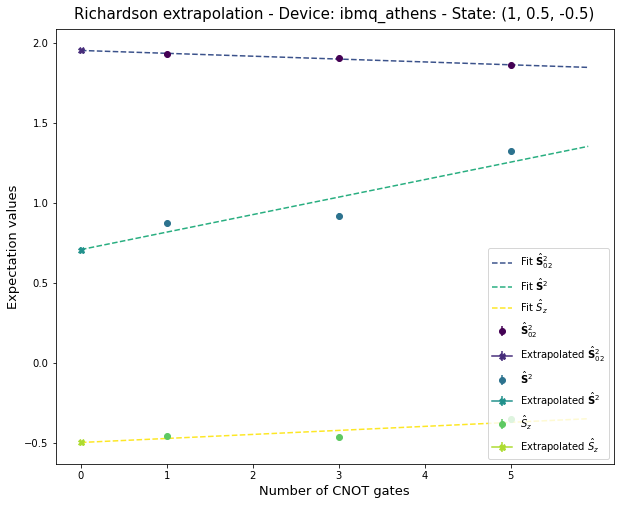

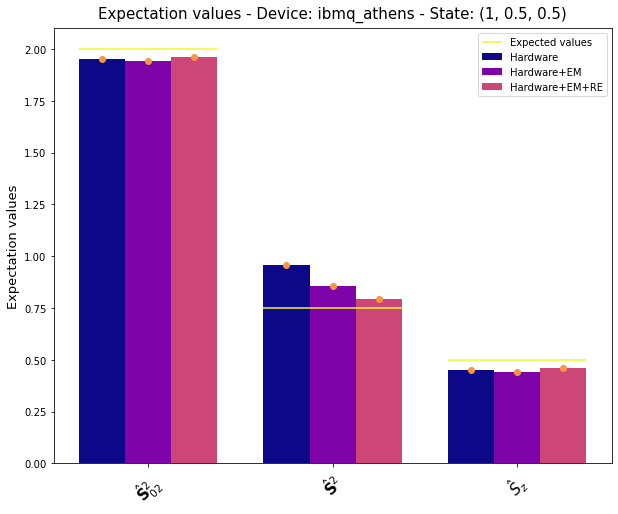

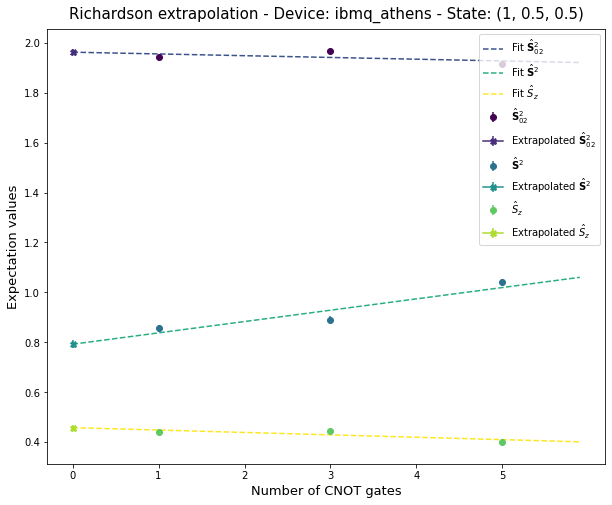

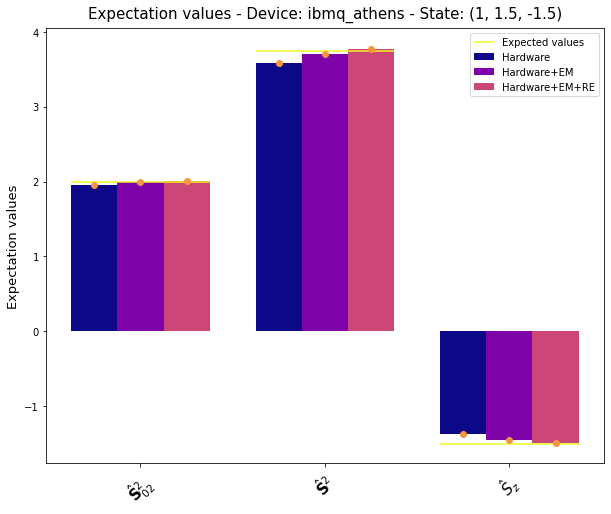

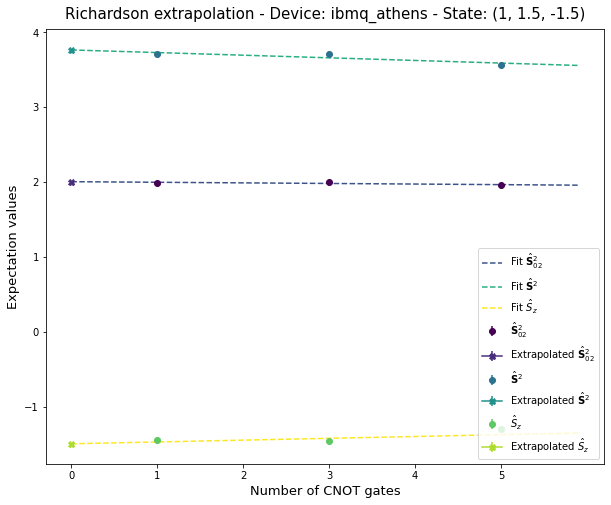

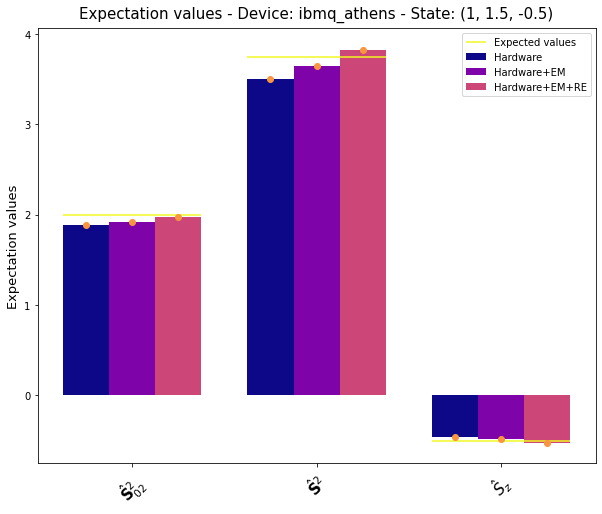

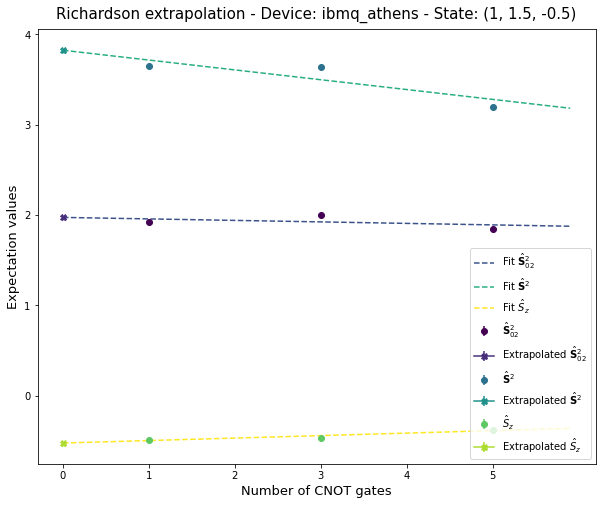

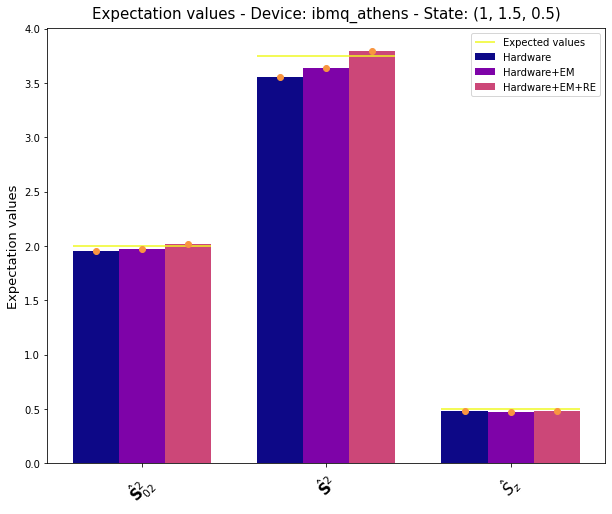

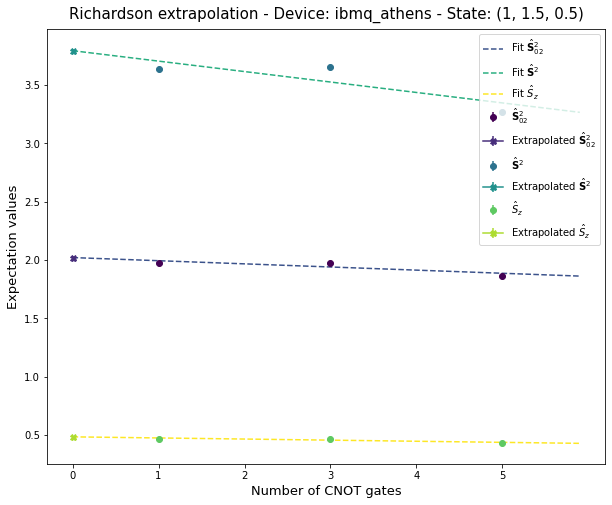

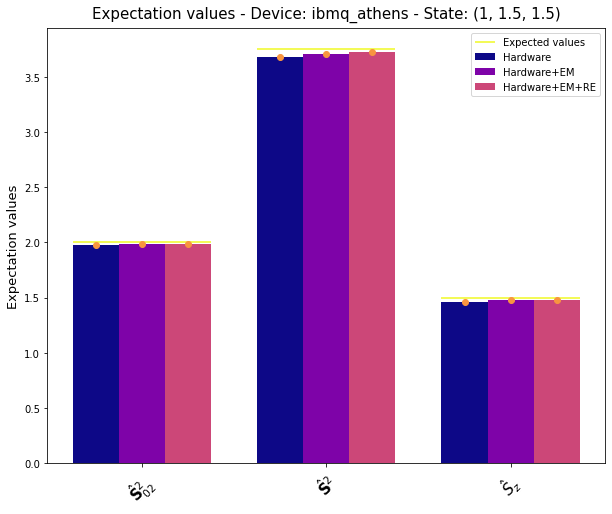

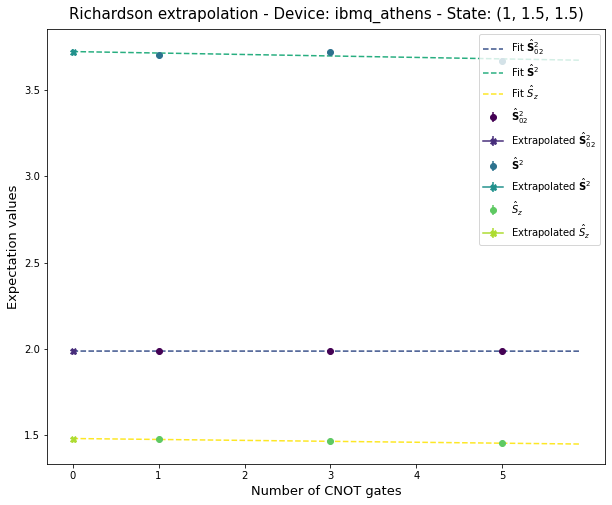

In [12]:
file = open("Results/CG_hardware.out")      # Before: VQE_spin_qasm_2.out
line = file.readlines()
line_val = []
for el in line:
    el2 = el.split()
    if el2[0]!="Job":
        line_val.append(el2)

s= 8192     # Number of shots
cl=0        # Count lines
for i in range(len(lab_list)):
    data_raw,err_raw=[],[]
    data_1,err_1=[],[]
    data_3,err_3=[],[]
    data_5,err_5=[],[]
    data_re,err_re=[],[]
    
    for j in range(12):
        val = line_val[cl]
        if j<3:
            data_raw.append(float(val[0]))
            err_raw.append(float(val[1]))    # Standard deviation!
        elif j>=3 and j<6:
            data_1.append(float(val[0]))
            err_1.append(float(val[1]))      # Standard deviation!
        elif j>=6 and j<9:
            data_3.append(float(val[0]))
            err_3.append(float(val[1]))      # Standard deviation!
        elif j>=9 and j<12:
            data_5.append(float(val[0]))
            err_5.append(float(val[1]))      # Standard deviation!
        cl+=1
    
    for k in range(len(data_1)):
        #print([data_1[k],data_3[k],data_5[k]])
        p_ave, p_cov = curve_fit(straight_line,[1,3,5],[data_1[k],data_3[k],data_5[k]],sigma=[err_1[k],err_3[k],err_5[k]],absolute_sigma=True)
        data_re.append(p_ave[1])
        err_re.append(np.sqrt(p_cov[1,1]))
                                                                                            
                                                                                             
    # The histograms - Plot of expectation values
    op_labels=[r"$\hat{\mathbf{S}}_{02}^2$",r"$\hat{\mathbf{S}}^2$",r"$\hat{S}_z$"]
    
    jet = plt.get_cmap('plasma')
    colors = iter(jet(np.linspace(0,1,5)))
    
    l = lab_list[i]
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab=np.arange(3)
    width=0.25

    rects1 = ax.bar(x_lab - width, data_raw, width, label='Hardware',color=next(colors))
    rects2 = ax.bar(x_lab, data_1, width, label='Hardware+EM',color=next(colors))
    rects3 = ax.bar(x_lab + width, data_re, width, label='Hardware+EM+RE',color=next(colors))
    
    c = next(colors)
    ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color=c)
    ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color=c)
    ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color=c)
    
    c = next(colors)
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors=c)
    ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors=c)
    ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors=c,label="Expected values")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=13)
    ax.set_title(r'Expectation values - Device: ibmq_athens - State: '+str(l),fontsize=15,pad=10)
    ax.set_xticks(x_lab)
    ax.set_xticklabels(op_labels,rotation=45,size=15)
    ax.legend()
    if i==0 or i==5:
        plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/CG_hardware_3_"+str(i)+".pdf")
    
    
    # Richardson extrapolation analysis
    jet = plt.get_cmap('viridis')
    colors = iter(jet(np.linspace(0,1,9)))
    
    plt.figure(figsize=(10,8))
    for j in range(3):
        # Data
        plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],marker='o',ls="none",label=op_labels[j],color=next(colors))
        # Extrapolated data
        p_ave,p_cov = curve_fit(straight_line,[1,3,5],[data_1[j],data_3[j],data_5[j]],sigma=[err_1[j],err_3[j],err_5[j]],absolute_sigma=True)                                                                                    
        plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+op_labels[j],color=next(colors))
        # Fit
        u = list(np.arange(0,6,0.1))
        v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
        plt.plot(u,v,'--',label='Fit '+op_labels[j], color=next(colors))                                                                                    
    
    plt.title("Richardson extrapolation - Device: ibmq_athens - State: "+str(l),size=15,pad=10)
    plt.xlabel("Number of CNOT gates",size=13)
    plt.xticks(np.arange(6))
    plt.ylabel("Expectation values",size=13)
    plt.legend()
    if i==0 or i==5:
        plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/CG_hardware_3_RE_"+str(i)+".pdf")
    

**Remark** The use of `absolute_sigma=True` considers the errors on $y$-data given inside the flag `sigma` as absolute errors.

### State tomography of  all circuits: fidelities and purities

We make the tomography using `ibmq_athens`.

In [9]:
for il in [0,5]:
    
    l = lab_list[il]

    circ    = QuantumCircuit(nqubits)

    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

    circ.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        # Alternative way to create a controlled-Hadamard
        #c_gate = HGate().control(1)
        #circ.append(c_gate,[1,0])
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]+0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]+0.5==-1:
            circ.cx(1,0)

    circ.x(1)

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]-0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]-0.5==-1:
            circ.cx(1,0)

    circ.x(1)
    circ.cx(0,2)
    print("Circuit associated with ",l)
    print(circ.draw())

    # Target state associated to the circuit on th first three qubits
    target_state = qiskit.quantum_info.Statevector.from_instruction(circ)

    # Generate circuits and run on simulator
    t = time.time()

    # Generate the state tomography circuit
    tomo_circ = state_tomography_circuits(circ,[0,1,2])

    #############
    # ibmq_athens
    #############

    # Execute
    job = qiskit.execute(tomo_circ, device, shots=8192)
    #print('Time taken:', time.time() - t)

    # Fit result
    tomo_fitter = StateTomographyFitter(job.result(), tomo_circ)

    # NO CORRECTION
    # Perform the tomography fit which outputs a density matrix
    rho_fit = tomo_fitter.fit(method='lstsq')
    #print(rho_fit)
    fid  = qiskit.quantum_info.state_fidelity(rho_fit, target_state)
    print('State Fidelity (no correction): F = {:.5f}'.format(fid))

    # Generate the calibration circuits (Readout Error Mitigation)
    meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1,2])

    job_cal = qiskit.execute(meas_calibs, backend=device, shots=8192)
    meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

    # WITH CORRECTION
    correct_tomo_results = meas_fitter.filter.apply(job.result(), method='least_squares')
    tomo_mit = StateTomographyFitter(correct_tomo_results, tomo_circ)
    rho_fit_mit = tomo_mit.fit(method='lstsq')
    fid_mit = qiskit.quantum_info.state_fidelity(rho_fit_mit, target_state)
    print('State fidelity (w/ correction): F = {:.5f}'.format(fid_mit))

    print("Purity: ",qiskit.quantum_info.purity(rho_fit_mit))

Circuit associated with  (0, 0.5, -0.5)
              ┌───┐┌───┐          ┌───┐┌───┐               
q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──
     ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  
q_1: ┤ RY(π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──
     └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐
q_2: ───────────────────┤ X ├───────────────┤ X ├─────┤ X ├
                        └───┘               └───┘     └───┘
State Fidelity (no correction): F = 0.84324


KeyboardInterrupt: 

## The $3$-spin Clebsch-Gordan circuits on a $5$-system register

We observed that the errors inside the previous simulation could be linked with the use of an hardware device where the $4$th and $5$th qubits are not used. We are going to involve those two qubits inside the quantum register and we will calculate the expectation value by measuring the identity operator, $\mathbb{I}$.

#### Definition of spin operators acting on $5$ qubits

They are defined by the correspongin operators on $3$ qubits and adding the tensor product with $\mathbb{1}_4\mathbb{1}_5$ on $4$th and $5$th qubits.

In [9]:
op_s2_5   = (I^I^op_s2)
op_s022_5 = (I^I^op_s022)
op_sz_5   = (I^I^op_sz)
op_sl2_5  = (I^I^op_sl2)
#print(op_s2_5.to_pauli_op())

## $|s_L = 0, s= 1/2, s_z = -1/2 \rangle$

Now we describe the circuit as acting on $5$ qubits.

We notice that the gates of the circuit are without any gate on $4$th and $5$th qubit.

In [12]:
s = 8192
l = lab_list[0]
    
################################
# Definition of the circuit
################################

circ    = QuantumCircuit(5)

# theta gives the angle to use in the Ry Gate
theta = np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

circ.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

if l[0]==0:
    circ.cx(1,0)
    circ.ch(1,0)
    # Alternative way to create a controlled-Hadamard
    #c_gate = HGate().control(1)
    #circ.append(c_gate,[1,0])
    circ.cx(1,2)

elif l[0]==1:
    if l[2]+0.5==0:
        circ.ch(1,0)
        circ.cx(1,2)
    elif l[2]+0.5==-1:
        circ.cx(1,0)

circ.x(1)

if l[0]==0:
    circ.cx(1,0)
    circ.ch(1,0)
    circ.cx(1,2)

elif l[0]==1:
    if l[2]-0.5==0:
        circ.ch(1,0)
        circ.cx(1,2)
    elif l[2]-0.5==-1:
        circ.cx(1,0)

circ.x(1)
circ.cx(0,2)
print("Circuit associated with ",l)
print(circ.draw())

Circuit associated with  (0, 0.5, -0.5)
              ┌───┐┌───┐          ┌───┐┌───┐               
q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──
     ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  
q_1: ┤ RY(π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──
     └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐
q_2: ───────────────────┤ X ├───────────────┤ X ├─────┤ X ├
                        └───┘               └───┘     └───┘
q_3: ──────────────────────────────────────────────────────
                                                           
q_4: ──────────────────────────────────────────────────────
                                                           


### Expectation values and corresponding Richardson extrapolation 

BEFORE TRANSPILATION - Operations =  OrderedDict([('cx', 5), ('ch', 2), ('x', 2), ('ry', 1)])  , Depth =  9
AFTER TRANSPILATION - Operations =  OrderedDict([('cx', 11), ('rz', 7), ('sx', 6), ('x', 2)])  , Depth =  18
Job pending Job completed
Job pending Job completed
Job pending Job completed
Job pending Job completed
Job pending Job completed
Job pending Job completed
Job pending Job completed
Job pending Job completed
Job pending Job completed
Job pending Job completed
Job pending Job completed
Job pending Job completed


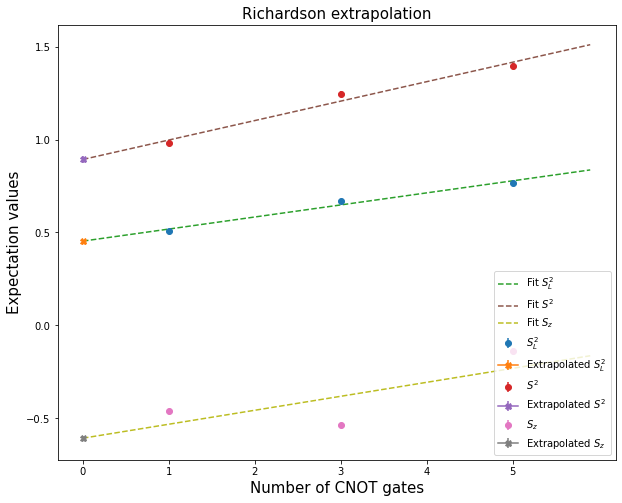

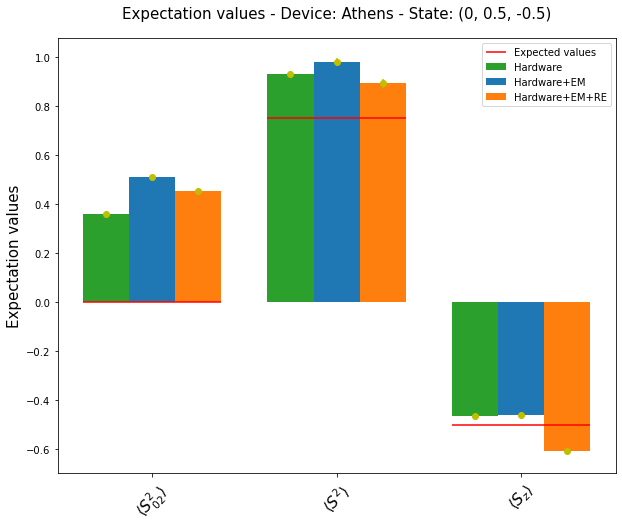

In [16]:
################################
# Measurement operations
################################

print("BEFORE TRANSPILATION - Operations = ",circ.count_ops()," , Depth = ",circ.depth())

# Search of best optimization level and layout
optimal_circuit = circ
optimal_layout  = np.arange(5)
min_depth       = 1000
optimal_level   = 3

for level in [0,1,2,3]:
    if np.all(l==lab_list[2]) or np.all(l==lab_list[5]):
        print("Circuit equal after transpilation")
        break
    for idx in itertools.permutations([0,1,2,3,4]):
        from qiskit.compiler import transpile
        qc_transpiled = transpile(circ,device,optimization_level=level,initial_layout=list(idx))
        #print("With order  ",idx," and level ",level)
        #print("OPERATIONS: ",qc_transpiled.count_ops())
        #print("DEPTH:      ",qc_transpiled.depth(),"\n")
        if(qc_transpiled.depth()<min_depth):
            min_depth       = qc_transpiled.depth()
            optimal_layout  = list(idx)
            optimal_level   = level
            optimal_circuit = qc_transpiled

#print(optimal_circuit.draw())
print("AFTER TRANSPILATION - Operations = ",optimal_circuit.count_ops()," , Depth = ",optimal_circuit.depth())

# Hardware
instance = QuantumInstance(backend                          = device,
                           shots                            = s,
                           coupling_map                     = device.configuration().coupling_map,
                           optimization_level               = optimal_level,
                           initial_layout                   = optimal_layout)

res_raw = []
res_raw.append(measure(op_s022_5,circ,instance))
res_raw.append(measure(op_s2_5,circ,instance))
res_raw.append(measure(op_sz_5,circ,instance))

# Hardware + readout error mitigation
instance = QuantumInstance(backend                          = device,
                           shots                            = s,
                           coupling_map                     = device.configuration().coupling_map,
                           measurement_error_mitigation_cls = CompleteMeasFitter, # <=====
                           optimization_level               = optimal_level,
                           initial_layout                   = optimal_layout)
res_1=[]
res_1.append(measure(op_s022_5,circ,instance))
res_1.append(measure(op_s2_5,circ,instance))
res_1.append(measure(op_sz_5,circ,instance))
#for el in res_1:
#    print(el[0]," ",el[1])

# Noise model + measurement error mitigation + Richardson extrapolation

# Building the circuit with CNOT and CH multiplication
# MULTIPLICATION BY 3
qr      = QuantumRegister(5,'q')
circ_R  = QuantumCircuit(qr)

for g in circ: # loop over gates in circ
    instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
    #print(instruction.name)
    if(instruction.name=='cx'): # if cnot, replicate
        circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
        circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
        circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
    elif(instruction.name=='u3'): # if u3, copy and paste
        t1,t2,t3 = instruction.params
        circ_R.u3(t1,t2,t3,qubits[0])
    elif(instruction.name=='x'):
        circ_R.x(qubits[0])
    elif(instruction.name=='ry'): # if ry, copy and paste
        t1 = instruction.params[0]
        circ_R.ry(t1,qubits[0])
    elif(instruction.name=='ch'):
        circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
        circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
        circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
    #else:
    #    print("!!! ",instruction)

#print(circ_R.draw())

res_3=[]
res_3.append(measure(op_s022_5,circ_R,instance))
res_3.append(measure(op_s2_5,circ_R,instance))
res_3.append(measure(op_sz_5,circ_R,instance))
#for el in res_3:
#    print(el[0]," ",el[1])

# MULTIPLICATION BY 5
qr      = QuantumRegister(5,'q')
circ_R  = QuantumCircuit(qr)

for g in circ: # loop over gates in circ
    instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
    #print(instruction.name)
    if(instruction.name=='cx'): # if cnot, replicate
        for k in range(5):
            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
    elif(instruction.name=='u3'): # if u3, copy and paste
        t1,t2,t3 = instruction.params
        circ_R.u3(t1,t2,t3,qubits[0])
    elif(instruction.name=='x'):
        circ_R.x(qubits[0])
    elif(instruction.name=='ry'): # if ry, copy and paste
        t1 = instruction.params[0]
        circ_R.ry(t1,qubits[0])
    elif(instruction.name=='ch'):
        for k in range(5):
            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
    #else:
    #    print("!!! ",instruction)

#print(circ_R.draw())

res_5=[]
res_5.append(measure(op_s022_5,circ_R,instance))
res_5.append(measure(op_s2_5,circ_R,instance))
res_5.append(measure(op_sz_5,circ_R,instance))
#for el in res_5:
#    print(el[0]," ",el[1])

res_richardson =[] 
# To use only if RE is made with multiplication by 3 of CH and CNOT
#for i in range(len(res_1)):
#    res_richardson.append( (res_1[i][0]+(res_1[i][0]-res_3[i][0])/2.0 , np.sqrt(res_1[i][1]**2+(res_1[i][1]**2+res_3[i][1]**2)/4.0 )))

################################
# Representation of the results
################################

# Richardson extrapolation analysis
plt.figure(figsize=(10,8))
op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]

for j in range(3):
    # Data
    plt.errorbar([1,3,5],[res_1[j][0],res_3[j][0],res_5[j][0]],yerr=[res_1[j][1],res_3[j][1],res_5[j][1]],marker='o',ls="none",label=op_labels[j])
    
    p_ave,p_cov = curve_fit(straight_line,[1,3,5],[res_1[j][0],res_3[j][0],res_5[j][0]],sigma=[res_1[j][1],res_3[j][1],res_5[j][1]],absolute_sigma=True)
    res_richardson.append( (p_ave[1],np.sqrt(p_cov[1,1])) )
    
    # Alternative for linear regression (re-check before using!)
    #coeff = np.polyfit([1,3,5],[res_1[j][0],res_3[j][0],res_5[j][0]],1)
    #res_richardson.append( (coeff[1],extr_dev_std([1,3,5],[res_1[j][1],res_3[j][1],res_5[j][1]])) )
    #poly1d_fn = np.poly1d(coeff) # poly1d_fn is now a function which takes in x and returns an estimate for y
    
    # Extrapolated data
    plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+op_labels[j])
    u = list(np.arange(0,6,0.1))
    v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
    plt.plot(u,v,'--',label='Fit '+op_labels[j])

plt.title("Richardson extrapolation",size=15)
plt.xlabel("Number of CNOT gates",size=15)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=15)
plt.legend()

# The histograms - Plot of expectation values
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

data=[]
err_data=[]
for el in res_raw:
    data.append(el[0])
    err_data.append(el[1])

rects1 = ax.bar(x_lab - width, data, width, label='Hardware',color='tab:green')
ax.errorbar(x_lab - width,data,yerr=err_data,fmt='o',color='y')

data=[]
err_data=[]
for el in res_1:
    data.append(el[0])
    err_data.append(el[1])

rects2 = ax.bar(x_lab, data, width, label='Hardware+EM',color='tab:blue')
ax.errorbar(x_lab,data,yerr=err_data,fmt='o',color='y')

data=[]
err_data=[]
for el in res_richardson:
    data.append(el[0])
    err_data.append(el[1])        # Already standard deviation from extr_dev_std

rects3 = ax.bar(x_lab + width, data, width, label='Hardware+EM+RE',color='tab:orange')
ax.errorbar(x_lab + width,data,yerr=err_data,fmt='o',color='y')

ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_{02}^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()


## State tomography of $|s_L=0,s = 1/2, s_z = -1/2 \rangle$ circuit on the $5$-qubit register

We make the state tomography using `ibmq_athens`. By using the IBM devices as an external user we cannot pass more than $75$ circuits to the method `qiskit.execute`. As a consequence we can't make a state tomography on the whole $5$-qubit register. We are going to make two state tomographies: one on the first three qubits ($\rho_{012}$) and one on the last two ($\rho_{34}$).

<img src="Pictures/Tomography.png" width="700">

#### Some references

- https://qiskit.org/documentation/tutorials/noise/8_tomography.html
- https://qiskit.org/documentation/stubs/qiskit.ignis.verification.state_tomography_circuits.html
- https://qiskit.org/documentation/stubs/qiskit.ignis.verification.StateTomographyFitter.html

In [13]:
l = lab_list[0]

circ3    = QuantumCircuit(nqubits)

# theta gives the angle to use in the Ry Gate
theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

circ3.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

if l[0]==0:
    circ3.cx(1,0)
    circ3.ch(1,0)
    # Alternative way to create a controlled-Hadamard
    #c_gate = HGate().control(1)
    #circ3.append(c_gate,[1,0])
    circ3.cx(1,2)

elif l[0]==1:
    if l[2]+0.5==0:
        circ3.ch(1,0)
        circ3.cx(1,2)
    elif l[2]+0.5==-1:
        circ3.cx(1,0)

circ3.x(1)

if l[0]==0:
    circ3.cx(1,0)
    circ3.ch(1,0)
    circ3.cx(1,2)

elif l[0]==1:
    if l[2]-0.5==0:
        circ3.ch(1,0)
        circ3.cx(1,2)
    elif l[2]-0.5==-1:
        circ3.cx(1,0)

circ3.x(1)
circ3.cx(0,2)


print("Circuit associated with state ",lab_list[0]," on 5 qubits")
print(circ.draw())

################################
# Analysis of the first 3 qubits
################################

backend = Aer.get_backend("qasm_simulator")

print("Analysis of the first 3 qubits")
# Target state associated to the circuit on th first three qubits
target_state = qiskit.quantum_info.Statevector.from_instruction(circ3)

# Generate circuits and run on simulator
t = time.time()

# Generate the state tomography circuit
tomo_circ = state_tomography_circuits(circ,[0,1,2])

# Execute
job = qiskit.execute(tomo_circ, device, shots=8192)
#print('Time taken:', time.time() - t)

# Fit result
tomo_fitter = StateTomographyFitter(job.result(), tomo_circ)

# NO CORRECTION
# Perform the tomography fit which outputs a density matrix
rho_fit = tomo_fitter.fit(method='lstsq')
fid  = qiskit.quantum_info.state_fidelity(rho_fit, target_state)
print('State Fidelity (no correction): F = {:.5f}'.format(fid))

# Generate the calibration circuits (Readout Error Mitigation)
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1,2])

job_cal = qiskit.execute(meas_calibs, device, shots=8192)
meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

# WITH CORRECTION
correct_tomo_results = meas_fitter.filter.apply(job.result(), method='least_squares')
tomo_mit = StateTomographyFitter(correct_tomo_results, tomo_circ)
rho_fit_mit = tomo_mit.fit(method='lstsq')
fid_mit = qiskit.quantum_info.state_fidelity(rho_fit_mit, target_state)
print('State fidelity (w/ correction): F = {:.5f}'.format(fid_mit))

################################
# Analysis of the last 2 qubits
################################

print("\n")
print("Analysis of the last 2 qubits")
# Target state
qc = QuantumCircuit(2)
target_state2 = qiskit.quantum_info.Statevector.from_instruction(qc)
#print(target_state2)

# Generate circuits and run on simulator
t2 = time.time()

# Generate the state tomography circuit
tomo_circ2 = state_tomography_circuits(circ,[3,4])

# Execute
job2 = qiskit.execute(tomo_circ2, device, shots=8192)
#print('Time taken:', time.time() - t2)

# Fit result
tomo_fitter2 = StateTomographyFitter(job2.result(), tomo_circ2)

# NO CORRECTION
# Perform the tomography fit which outputs a density matrix
rho_fit2 = tomo_fitter2.fit(method='lstsq')
fid2  = qiskit.quantum_info.state_fidelity(rho_fit2, target_state2)
print('State Fidelity (no correction): F = {:.5f}'.format(fid2))

# Generate the calibration circuits (Readout Error Mitigation)
meas_calibs2, state_labels2 = mc.complete_meas_cal(qubit_list=[3,4])

job_cal2 = qiskit.execute(meas_calibs2, device, shots=8192)
meas_fitter2 = mc.CompleteMeasFitter(job_cal.result(),state_labels2)

# WITH CORRECTION
correct_tomo_results2 = meas_fitter2.filter.apply(job2.result(), method='least_squares')
tomo_mit2 = StateTomographyFitter(correct_tomo_results2, tomo_circ2)
rho_fit_mit2 = tomo_mit2.fit(method='lstsq')
fid_mit2 = qiskit.quantum_info.state_fidelity(rho_fit_mit2, target_state2)
print('State fidelity (w/ correction): F = {:.5f}'.format(fid_mit2))

Circuit associated with state  (0, 0.5, -0.5)  on 5 qubits
              ┌───┐┌───┐          ┌───┐┌───┐               
q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──
     ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  
q_1: ┤ RY(π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──
     └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐
q_2: ───────────────────┤ X ├───────────────┤ X ├─────┤ X ├
                        └───┘               └───┘     └───┘
q_3: ──────────────────────────────────────────────────────
                                                           
q_4: ──────────────────────────────────────────────────────
                                                           
Analysis of the first 3 qubits
State Fidelity (no correction): F = 0.84247
State fidelity (w/ correction): F = 0.95047


Analysis of the last 2 qubits
State Fidelity (no correction): F = 0.96230
State fidelity (w/ correction): F = 0.96735


**Question** Why the values of fidelity (without correction) change inside a range between around 0.60 to 0.80?

### Relaxation and decoherence on the last $2$ qubits

Those information can be found at the website of the **IBM Quantum Experience**.

**Reference**: https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/ignis/coherence-overview.ipynb

#### Evaluation of $T_1$ (relaxation)
The probability of measuring $|1\rangle$ in the selected qubit is given by:

$$f(t) = A e^{-t/T_1} + B$$

for unknown parameters $A$, $B$ and $T_1$.

In [ ]:
# 12 numbers ranging from 10 to 1000, logarithmically spaced
# extra point at 1500
num_of_gates = np.append((np.logspace(1, 3, 12)).astype(int), np.array([1500]))
gate_time = 0.1

# Select the qubits whose T1 are to be measured
# We select the last two qubits of the circuit shown above
qubits = [3,4]

# Generate experiments
circs, xdata = t1_circuits(num_of_gates, gate_time, qubits)
device_results = qiskit.execute(circs, device, shots=8192).result()

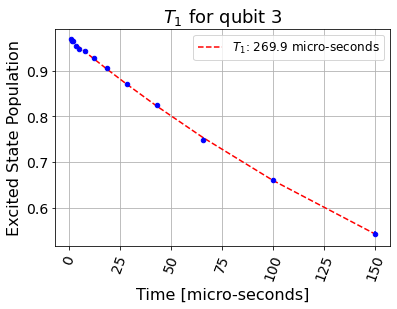

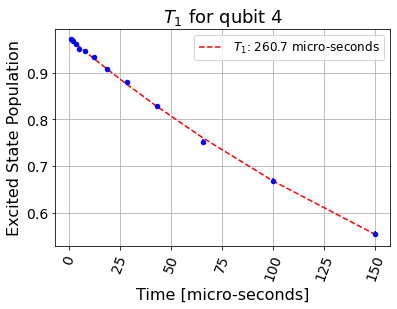

In [53]:
# Fit the data to an exponential
# The correct answers are A=1, B=0 and T1=25/15 for qubit 0/2
# The user does not know the correct answer exactly,
# so starts the fit from a different but close location
t1 = 705
initial_t1 = t1*1.2
initial_A = 1.0
initial_B = 0.0

fit = T1Fitter(device_results, xdata, qubits,
               fit_p0=[initial_A, initial_t1, initial_B],
               fit_bounds=([0, 0, -1], [2, initial_t1*2, 1]))

fit.plot(0)
fit.plot(1)

#### Evaluation of $T_2^*$ (decoherence)

We consider $T_2 \le T_2^*$, where $T_2^*$ accounts also for other decoherence rates associated with other noise processes. The probability of measuring $|0\rangle$ in the selected qubit is equal to:

$$g(t) = Ae^{-t/T_2^*}\cos(2\pi f t + \phi) + B$$

where $A$, $B$, $\phi$, $T_2^*$ and $f$ are parameters.

In [98]:
# 50 points linearly spaced in two regions (fine and coarse)
# 30 from 10->150, 20 from 160->450
num_of_gates2 = np.append((np.linspace(10, 150, 50)).astype(int), (np.linspace(160,450,50)).astype(int))

# Generate experiments
circs2, xdata2, osc_freq = t2star_circuits(num_of_gates, gate_time, qubits, nosc=5)
device_results2 = qiskit.execute(circs2, device, shots=8192).result()

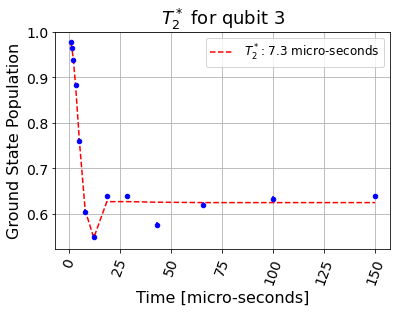

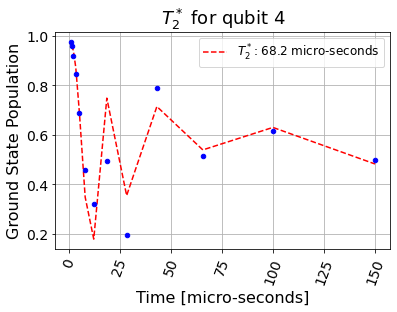

In [111]:
# Fit the data to an oscillator
# The correct answers are a=0.5, f=osc_freq, phi=0, c=0.5, and t2=10/5 for qubit 0/2
# The user does not know the correct answer exactly,
# so starts the fit from a different but close location
t2 = 10
initial_t2 = t2*100
initial_A = 5.
initial_B = 0.65
initial_f = osc_freq*2
initial_phi = -np.pi/20

fit = T2StarFitter(device_results2, xdata2, qubits,
                   fit_p0=[initial_A, initial_t2, initial_f, initial_phi, initial_B],
                   fit_bounds=([-0.5, 0, 0, -np.pi, -0.5], [5, 100*t2, 100*osc_freq, np.pi, 1.5]))

fit.plot(0)
fit.plot(1)

**Question** Is there any possibility to analyze the previous times $T_1$ and $T_2^*$ while the first three qubits are running the spin circuit?

### Analysis of mitigated $\rho_{012}$ and $\rho_{34}$

#### Purity, Tr$ \Bigl( | \psi_i \rangle \langle \psi_i | \rho_{012} \Bigr)$ and $|\langle \psi_i |\psi_{ideal} \rangle |^2$

We are going to evaluate: 
- $\text{Tr}\Bigl( \rho_{012}^2 \Bigr)$  and $\text{Tr}\Bigl( \rho_{34}^2 \Bigr)$ (**purities**);
- Tr$ \Bigl( | \psi_i \rangle \langle \psi_i | \rho_{012} \Bigr)$ where $|\psi_i \rangle$ is the $i$-th eigenstate of diagonalized $\rho_{012}$ ;
- $|\langle \psi_i |\psi_{ideal} \rangle |^2$ where $|\psi_{ideal} \rangle$ is the eigenstate associate with state $(0,1/2,-1/2)$.

From the trace values we expect the eigenvalues of the density matrices $\rho_{012}$ and $\rho_{34}$! 

In [14]:
print("Purity of rho_{012} = ", qiskit.quantum_info.purity(rho_fit_mit))
print("Purity of rho_{34} = ", qiskit.quantum_info.purity(rho_fit_mit2),"\n")

# Diagonalization of rho_{012}: returns eigenvalues and corresponding eigenvectors 
e,U   = LA.eigh(rho_fit_mit)
e2,U2 = LA.eigh(rho_fit_mit2)

print("Diagonalization of rho_{012} and rho_{34}")
rho1 = np.real(np.round(np.dot(LA.inv(U),np.dot(rho_fit_mit,U)),4))
#print(rho1)

rho2 = np.real(np.round(np.dot(LA.inv(U2),np.dot(rho_fit_mit2,U2)),4))
#print(rho2)

display(Markdown(r"$T_i = \text{Tr}\Bigl(| \psi_i \rangle \langle \psi_i | \rho_{012} \Bigr)$ and fidelity $F_i = |\langle \psi_i |\psi_{ideal} \rangle |^2$"))

U_trans    = np.transpose(U)
sum_fid    = 0
sum_trace  = 0
fid, trace = [], []
for i in range(len(rho1)):
    fid.append(np.abs(np.dot(np.conjugate(target_state.data),U_trans[i]))**2)
    sum_fid   += fid[i]
    trace.append(np.dot(np.conjugate(U_trans[i]),np.dot(rho_fit_mit,U_trans[i])))
    sum_trace += trace[i]
    print("i =",i,": Trace = ",np.round(np.abs(trace[i]),4)," , Fidelity = ",np.round(fid[i],4))

#print("Sum of all fidelities values: ",sum_fid)
#print("Sum of all the traces: ",sum_trace)

Purity of rho_{012} =  (0.9254488648203956+0j)
Purity of rho_{34} =  (1.0000000000000002+0j) 

Diagonalization of rho_{012} and rho_{34}


$T_i = \text{Tr}\Bigl(| \psi_i \rangle \langle \psi_i | \rho_{012} \Bigr)$ and fidelity $F_i = |\langle \psi_i |\psi_{ideal} \rangle |^2$

i = 0 : Trace =  0.0  , Fidelity =  0.0016
i = 1 : Trace =  0.0  , Fidelity =  0.0031
i = 2 : Trace =  0.0  , Fidelity =  0.0001
i = 3 : Trace =  0.0  , Fidelity =  0.0017
i = 4 : Trace =  0.0  , Fidelity =  0.0018
i = 5 : Trace =  0.0032  , Fidelity =  0.001
i = 6 : Trace =  0.0354  , Fidelity =  0.0022
i = 7 : Trace =  0.9613  , Fidelity =  0.9886


If we find a similarity between the trace and the fidelity values, it suggests that the density matrix $\rho_{012}$ looks like the density matrix associated with the ideal state $|\psi_{ideal} \rangle \langle \psi_{ideal}|$. Indeed, $F_i = | \langle \psi_i | \psi_{ideal} \rangle |^2 = \text{Tr} \Bigl( |\psi_i \rangle \langle \psi_i| \psi_{ideal} \rangle \langle \psi_{ideal}|\Bigr)$.

#### Diagonalized matrices $\rho_{012}$ and $\rho_{34}$ and fidelities of eigenvectors

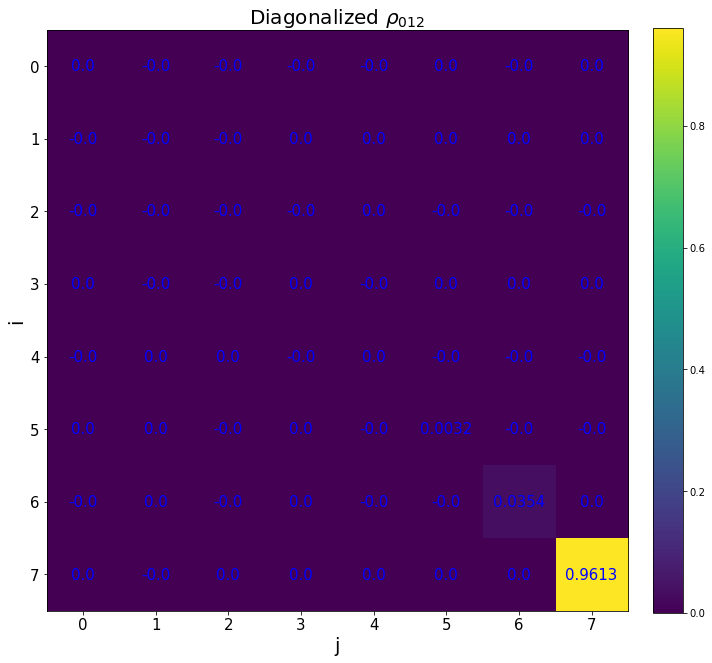

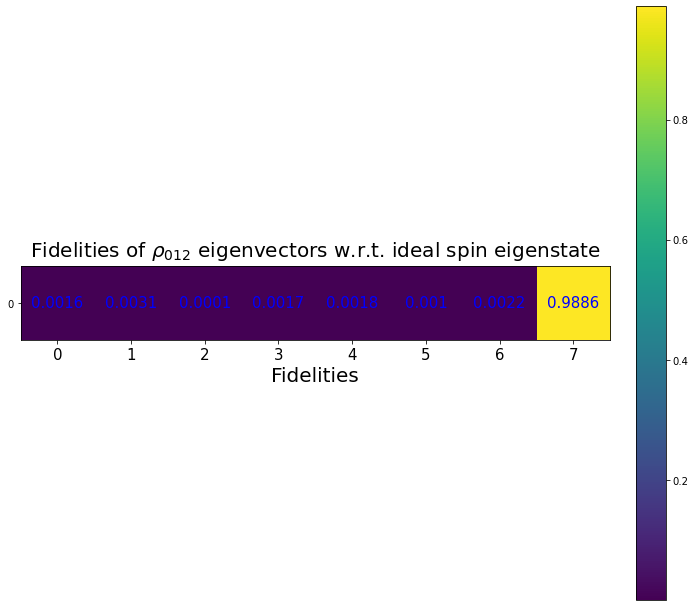

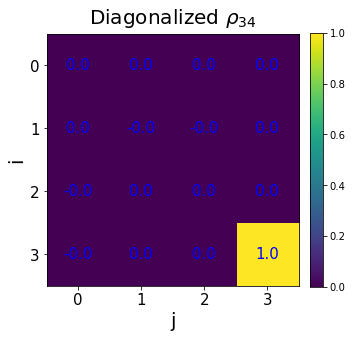

In [17]:
# Diagonalization of rho_{012}
fig, ax = plt.subplots(figsize=(10,12))
im = ax.imshow(rho1, cmap=plt.get_cmap('viridis'))

ax.set_xticks(np.arange(len(rho1)))
ax.set_yticks(np.arange(len(rho1)))
ax.set_xticklabels(np.arange(len(rho1)), fontsize=15)
ax.set_yticklabels(np.arange(len(rho1)), fontsize=15)

ax.set_xlabel("j",fontsize=20)
ax.set_ylabel("i",fontsize=20)

fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)
for i in range(len(rho1)):
    for j in range(len(rho1)):
        text = ax.text(j, i, round(rho1[i, j],4), ha="center", va="center", color="b", fontsize=15)
ax.set_title(r"Diagonalized $\rho_{012}$", fontsize=20)
fig.tight_layout()
plt.show()

# Fidelities of corresponding rho_{012} eigenvectors
M_fid = []
M_fid.append(fid)
#print(M_fid)

fig, ax = plt.subplots(figsize=(10,12))
im = ax.imshow(M_fid)

ax.set_xticks(np.arange(len(fid)))
ax.set_yticks(np.arange(1))
ax.set_xticklabels(np.arange(len(fid)), fontsize=15)
#ax.set_yticklabels(np.arange(len(rho1)), fontsize=15)

ax.set_xlabel("Fidelities",fontsize=20)
#ax.set_ylabel("i",fontsize=20)

fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)
for j in range(len(fid)):
    text = ax.text(j, 0, np.round(fid[j],4), ha="center", va="center", color="b", fontsize=15)
ax.set_title(r"Fidelities of $\rho_{012}$ eigenvectors w.r.t. ideal spin eigenstate", fontsize=20,pad=10)
fig.tight_layout()
plt.show()

# Diagonalization of rho_{34}
fig, ax = plt.subplots(figsize=(5,7))
im = ax.imshow(rho2)

ax.set_xticks(np.arange(len(rho2)))
ax.set_yticks(np.arange(len(rho2)))
ax.set_xticklabels(np.arange(len(rho2)), fontsize=15)
ax.set_yticklabels(np.arange(len(rho2)), fontsize=15)

ax.set_xlabel("j",fontsize=20)
ax.set_ylabel("i",fontsize=20)

fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)
for i in range(len(rho2)):
    for j in range(len(rho2)):
        text = ax.text(j, i, round(rho2[i, j],4), ha="center", va="center", color="b", fontsize=15)
ax.set_title(r"Diagonalized $\rho_{34}$", fontsize=20,pad=10)
fig.tight_layout()
plt.show()

## Mario's analysis

We are going to look at: $\rho_{target} = |\psi_{target} \rangle \langle \psi_{target}|$ (where $|\psi_{target}\rangle \equiv |\psi_{ideal}\rangle$ ideal spin eigenstate), $\rho_{012} \equiv \rho_{hardware}$ and $\rho_{dominant \, eigenvector} \equiv \rho_{top} = |\psi_{top} \rangle \langle \psi_{top}|$. Then we compute the fidelities:

- $F(\rho_{012}, |\psi_{target}\rangle) = \text{Tr}\Bigl(  |\psi_{target}\rangle \langle \psi_{target} | \rho_{012}\Bigr)$
- $F(|\psi_{target}\rangle, |\psi_{top}\rangle) = | \langle \psi_{target}|\psi_{top}\rangle|^2$
- $F(\rho_{012}, |\psi_{top}\rangle) = \text{Tr}\Bigl(  |\psi_{top}\rangle \langle \psi_{top} | \rho_{012}\Bigr)$

F(hardware,target)   =  0.6360524443127009
F(target,dominant)   =  0.993777997917554
F(hardware,dominant) =  0.639502194069538


$\text{Legend}$

$ \rho_{target} = |\psi_{target} \rangle \langle \psi_{target}| \quad \text{where} \quad |\psi_{target} \rangle = | s_L = 0, s = 1/2,s_z = -1/2\rangle$

$ \rho_{012} \equiv \rho_{hardware}$

$ |\psi_{top} \rangle \equiv | \psi_{dominant \, eigenvector} \rangle \quad \text{associated with biggest eigenvalue of} \, \rho_{012}$

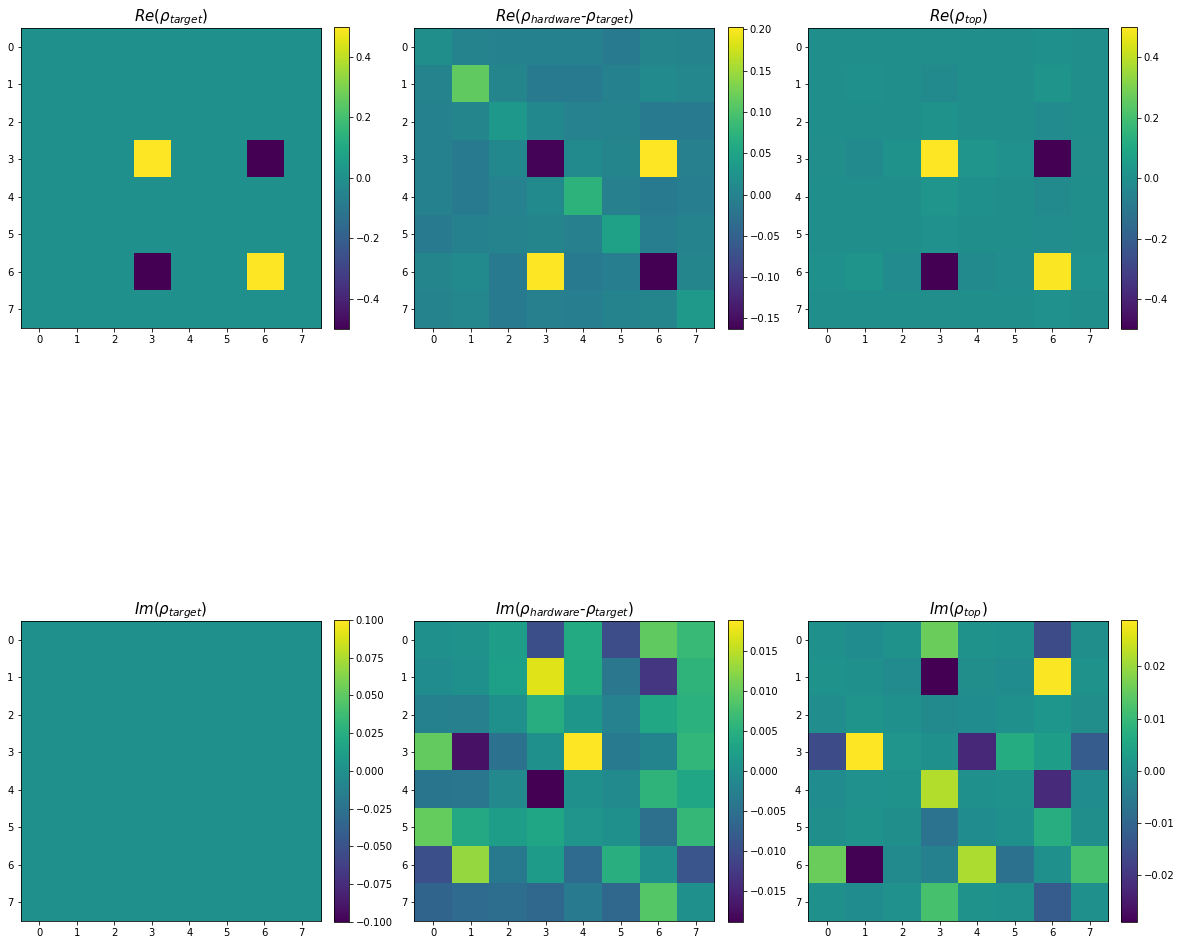

In [20]:
# R_target is the density matrix
# R_target = | psi(target) >< psi(target) |
psi_target  = target_state.data
psi_target /= LA.norm(target_state.data) 
R_target    = np.einsum('i,j->ij',np.conj(psi_target),psi_target)

# R_hardware is the density matrix associated with the hardware
R_hardware = rho_fit_mit

# Now after taking the dominant eigenvalue I take the projector associated with the corresponding eigenvalue
i = np.argmax(e)
psi_dominant = U[:,i]
R_dominant   = np.einsum('i,j->ij',np.conj(psi_dominant),psi_dominant)

# Plots with all the matrices
fig,ax = plt.subplots(2,3,figsize=(20,20))
c0 = ax[0,0].imshow(np.real(R_target));            plt.colorbar(c0,ax=ax[0,0],orientation='vertical',fraction=0.046, pad=0.04); ax[0,0].set_title(r'$Re(\rho_{target})$',size=15)
c1 = ax[0,1].imshow(np.real(R_hardware-R_target)); plt.colorbar(c1,ax=ax[0,1],orientation='vertical',fraction=0.046, pad=0.04); ax[0,1].set_title(r'$Re (\rho_{hardware}$-$\rho_{target} )$',size=15)
c2 = ax[0,2].imshow(np.real(R_dominant));          plt.colorbar(c2,ax=ax[0,2],orientation='vertical',fraction=0.046, pad=0.04); ax[0,2].set_title(r'$Re(\rho_{top})$',size=15)
c0 = ax[1,0].imshow(np.imag(R_target));            plt.colorbar(c0,ax=ax[1,0],orientation='vertical',fraction=0.046, pad=0.04); ax[1,0].set_title(r'$Im(\rho_{target})$',size=15)
c1 = ax[1,1].imshow(np.imag(R_hardware-R_target)); plt.colorbar(c1,ax=ax[1,1],orientation='vertical',fraction=0.046, pad=0.04); ax[1,1].set_title(r'$Im ( \rho_{hardware}$-$\rho_{target} )$',size=15)
c2 = ax[1,2].imshow(np.imag(R_dominant));          plt.colorbar(c2,ax=ax[1,2],orientation='vertical',fraction=0.046, pad=0.04); ax[1,2].set_title(r'$Im(\rho_{top})$',size=15)

# fidelities, remembering that F(rho,psi) = <psi|rho|psi> and F(psi,phi) = |<psi|phi>|^2
# for simplicity we use real values
print("F(hardware,target)   = ",np.abs(np.einsum('i,ij,j->',np.conj(psi_target),R_hardware,psi_target)))
print("F(target,dominant)   = ",np.abs(np.einsum('i,i->',np.conj(psi_target),psi_dominant))**2)
print("F(hardware,dominant) = ",np.abs(np.einsum('i,ij,j->',np.conj(psi_dominant),R_hardware,psi_dominant)))

display(Markdown(r"$\text{Legend}$"))
display(Markdown(r"$ \rho_{target} = |\psi_{target} \rangle \langle \psi_{target}| \quad \text{where} \quad |\psi_{target} \rangle = | s_L = 0, s = 1/2,s_z = -1/2\rangle$"))
display(Markdown(r"$ \rho_{012} \equiv \rho_{hardware}$"))
display(Markdown(r"$ |\psi_{top} \rangle \equiv | \psi_{dominant \, eigenvector} \rangle \quad \text{associated with biggest eigenvalue of} \, \rho_{012}$"))

plt.show()

## Barbara's analysis

### A) State tomography with Richardson extrapolation

We can look at the fidelity $F(\rho_{target},\rho_{012})$ as the expectation value on a specific operator. We remind that $\rho_{target} = |\psi_{target} \rangle \langle \psi_{target}|$ is a pure state and $|\psi_{target} \rangle = |s_L=0,s=1/2,s_z=-1/2 \rangle$.

$$F(\rho_{target},\rho_{012}) = \Bigl( \text{Tr} \sqrt{\sqrt{\rho_{target}}\rho_{012}\sqrt{\rho_{target}}} \Bigr)^2 = \langle \psi_{target}| \rho_{012} |\psi_{target} \rangle$$

In [118]:
s = 8192
l = lab_list[0]
    
################################
# Definition of the circuit
################################

circ    = QuantumCircuit(5)

# theta gives the angle to use in the Ry Gate
theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

circ.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

if l[0]==0:
    circ.cx(1,0)
    circ.ch(1,0)
    # Alternative way to create a controlled-Hadamard
    #c_gate = HGate().control(1)
    #circ.append(c_gate,[1,0])
    circ.cx(1,2)

elif l[0]==1:
    if l[2]+0.5==0:
        circ.ch(1,0)
        circ.cx(1,2)
    elif l[2]+0.5==-1:
        circ.cx(1,0)

circ.x(1)

if l[0]==0:
    circ.cx(1,0)
    circ.ch(1,0)
    circ.cx(1,2)

elif l[0]==1:
    if l[2]-0.5==0:
        circ.ch(1,0)
        circ.cx(1,2)
    elif l[2]-0.5==-1:
        circ.cx(1,0)

circ.x(1)
circ.cx(0,2)
print("Circuit associated with ",l)
print(circ.draw())

###################
# NO MULTIPLICATION
###################

# Generate the state tomography circuit
tomo_circ = state_tomography_circuits(circ,[0,1,2])

# Execute
job = qiskit.execute(tomo_circ, device, shots=8192)

# Generate the calibration circuits (Readout Error Mitigation)
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1,2])

job_cal = qiskit.execute(meas_calibs, device, shots=8192)
meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

# WITH READOUT ERROR MITIGATION
correct_tomo_results = meas_fitter.filter.apply(job.result(), method='least_squares')
tomo_mit = StateTomographyFitter(correct_tomo_results, tomo_circ)
rho_fit_mit = tomo_mit.fit(method='lstsq')
fid_mit = qiskit.quantum_info.state_fidelity(rho_fit_mit, target_state)
print('#CNOT = 1 - State fidelity (w/ correction): F = {:.5f}'.format(fid_mit))

# Hardware + measurement error mitigation + Richardson extrapolation

######################################
# CIRCUIT for RE - MULTIPLICATION BY 3
######################################

circ_R = QuantumCircuit(5)

for g in circ: # loop over gates in circ
    instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
    #print(instruction.name)
    if(instruction.name=='cx'): # if cnot, replicate
        circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
        circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
        circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
    elif(instruction.name=='u3'): # if u3, copy and paste
        t1,t2,t3 = instruction.params
        circ_R.u3(t1,t2,t3,qubits[0])
    elif(instruction.name=='x'):
        circ_R.x(qubits[0])
    elif(instruction.name=='ry'): # if ry, copy and paste
        t1 = instruction.params[0]
        circ_R.ry(t1,qubits[0])
    elif(instruction.name=='ch'):
        circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
        circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
        circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
    #else:
    #    print("!!! ",instruction)

#print(circ_R.draw())

# Generate the state tomography circuit
tomo_circ3 = state_tomography_circuits(circ_R,[0,1,2])

# Execute
job3 = qiskit.execute(tomo_circ3, device, shots=8192)

# Generate the calibration circuits (Readout Error Mitigation)
meas_calibs3, state_labels3 = mc.complete_meas_cal(qubit_list=[0,1,2])

job_cal3 = qiskit.execute(meas_calibs3, device, shots=8192)
meas_fitter3 = mc.CompleteMeasFitter(job_cal3.result(),state_labels3)

# WITH READOUT ERROR MITIGATION
correct_tomo_results3 = meas_fitter3.filter.apply(job3.result(), method='least_squares')
tomo_mit3 = StateTomographyFitter(correct_tomo_results3, tomo_circ3)
rho_fit_mit3 = tomo_mit3.fit(method='lstsq')
fid_mit3 = qiskit.quantum_info.state_fidelity(rho_fit_mit3, target_state)
print('#CNOT = 3 - State fidelity (w/ correction): F = {:.5f}'.format(fid_mit3))

######################################
# CIRCUIT for RE - MULTIPLICATION BY 5
######################################

circ_R  = QuantumCircuit(5)

for g in circ: # loop over gates in circ
    instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
    #print(instruction.name)
    if(instruction.name=='cx'): # if cnot, replicate
        for k in range(5):
            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
    elif(instruction.name=='u3'): # if u3, copy and paste
        t1,t2,t3 = instruction.params
        circ_R.u3(t1,t2,t3,qubits[0])
    elif(instruction.name=='x'):
        circ_R.x(qubits[0])
    elif(instruction.name=='ry'): # if ry, copy and paste
        t1 = instruction.params[0]
        circ_R.ry(t1,qubits[0])
    elif(instruction.name=='ch'):
        for k in range(5):
            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
    else:
        print("!!! ",instruction)

#print(circ_R.draw())

# Generate the state tomography circuit
tomo_circ5 = state_tomography_circuits(circ_R,[0,1,2])

# Execute
job5 = qiskit.execute(tomo_circ5, device, shots=8192)

# Generate the calibration circuits (Readout Error Mitigation)
meas_calibs5, state_labels5 = mc.complete_meas_cal(qubit_list=[0,1,2])

job_cal5 = qiskit.execute(meas_calibs5, device, shots=8192)
meas_fitter5 = mc.CompleteMeasFitter(job_cal5.result(),state_labels5)

# WITH READOUT ERROR MITIGATION
correct_tomo_results5 = meas_fitter5.filter.apply(job5.result(), method='least_squares')
tomo_mit5 = StateTomographyFitter(correct_tomo_results5, tomo_circ5)
rho_fit_mit5 = tomo_mit5.fit(method='lstsq')
fid_mit5 = qiskit.quantum_info.state_fidelity(rho_fit_mit5, target_state)
print('#CNOT = 5 - State fidelity (w/ correction): F = {:.5f}'.format(fid_mit5))

######################################
# CIRCUIT for RE - MULTIPLICATION BY 7
######################################

circ_R  = QuantumCircuit(5)

for g in circ: # loop over gates in circ
    instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
    #print(instruction.name)
    if(instruction.name=='cx'): # if cnot, replicate
        for k in range(7):
            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
    elif(instruction.name=='u3'): # if u3, copy and paste
        t1,t2,t3 = instruction.params
        circ_R.u3(t1,t2,t3,qubits[0])
    elif(instruction.name=='x'):
        circ_R.x(qubits[0])
    elif(instruction.name=='ry'): # if ry, copy and paste
        t1 = instruction.params[0]
        circ_R.ry(t1,qubits[0])
    elif(instruction.name=='ch'):
        for k in range(7):
            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
    else:
        print("!!! ",instruction)

#print(circ_R.draw())

# Generate the state tomography circuit
tomo_circ7 = state_tomography_circuits(circ_R,[0,1,2])

# Execute
job7 = qiskit.execute(tomo_circ7, device, shots=8192)

# Generate the calibration circuits (Readout Error Mitigation)
meas_calibs7, state_labels7 = mc.complete_meas_cal(qubit_list=[0,1,2])

job_cal7 = qiskit.execute(meas_calibs7, device, shots=8192)
meas_fitter7 = mc.CompleteMeasFitter(job_cal7.result(),state_labels7)

# WITH READOUT ERROR MITIGATION
correct_tomo_results7 = meas_fitter7.filter.apply(job7.result(), method='least_squares')
tomo_mit7 = StateTomographyFitter(correct_tomo_results7, tomo_circ7)
rho_fit_mit7 = tomo_mit7.fit(method='lstsq')
fid_mit7 = qiskit.quantum_info.state_fidelity(rho_fit_mit7, target_state)
print('#CNOT = 7 - State fidelity (w/ correction): F = {:.5f}'.format(fid_mit7))

Circuit associated with  (0, 0.5, -0.5)
              ┌───┐┌───┐          ┌───┐┌───┐               
q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──
     ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  
q_1: ┤ RY(π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──
     └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐
q_2: ───────────────────┤ X ├───────────────┤ X ├─────┤ X ├
                        └───┘               └───┘     └───┘
q_3: ──────────────────────────────────────────────────────
                                                           
q_4: ──────────────────────────────────────────────────────
                                                           
#CNOT = 1 - State fidelity (w/ correction): F = 0.90138
#CNOT = 3 - State fidelity (w/ correction): F = 0.74631
#CNOT = 5 - State fidelity (w/ correction): F = 0.62464
#CNOT = 7 - State fidelity (w/ correction): F = 0.50967


#### Plot of RE on fidelity

Extrapolated fidelity: 0.9548615637562735 +/- 0.01516283664030742


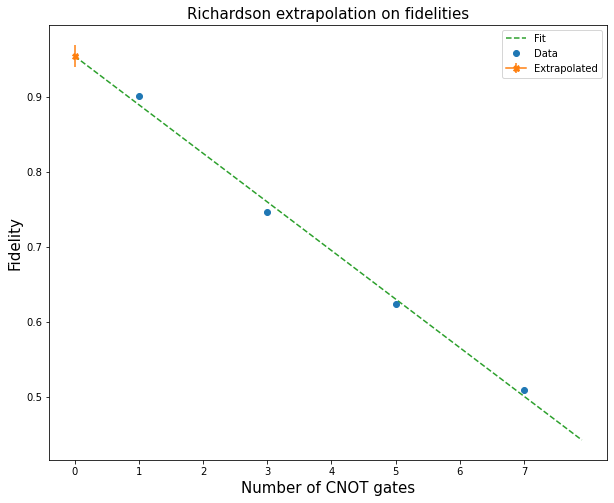

In [125]:
# Richardson extrapolation analysis
plt.figure(figsize=(10,8))


# Data
plt.errorbar([1,3,5,7],[fid_mit,fid_mit3,fid_mit5,fid_mit7],marker='o',ls="none",label="Data")

p_ave,p_cov = curve_fit(straight_line,[1,3,5,7],[fid_mit,fid_mit3,fid_mit5,fid_mit7],absolute_sigma=False)
# Extrapolated data
plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated')
u = list(np.arange(0,8,0.1))
v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
plt.plot(u,v,'--',label='Fit ')

plt.title("Richardson extrapolation on fidelities",size=15)
plt.xlabel("Number of CNOT gates",size=15)
plt.xticks(np.arange(8))
plt.ylabel("Fidelity",size=15)
plt.legend()

print("Extrapolated fidelity: {} +/- {}".format(p_ave[1],np.sqrt(p_cov[1,1])))

#### Purity: Tr$\Bigl( \rho_{012}^2\Bigr)$

In [120]:
print("1 CNOT - Purity of rho_{012} = ", qiskit.quantum_info.purity(rho_fit_mit))
print("3 CNOTs - Purity of rho_{012} = ", qiskit.quantum_info.purity(rho_fit_mit3))
print("5 CNOTs - Purity of rho_{012} = ", qiskit.quantum_info.purity(rho_fit_mit5))
print("7 CNOTs - Purity of rho_{012} = ", qiskit.quantum_info.purity(rho_fit_mit7))

1 CNOT - Purity of rho_{012} =  (0.8303191016768591+0j)
3 CNOTs - Purity of rho_{012} =  (0.6209203069550965+0j)
5 CNOTs - Purity of rho_{012} =  (0.49118183466588494+0j)
7 CNOTs - Purity of rho_{012} =  (0.3851670540807512+0j)


#### Analysis of $\rho_{012}$ number of CNOTs gates

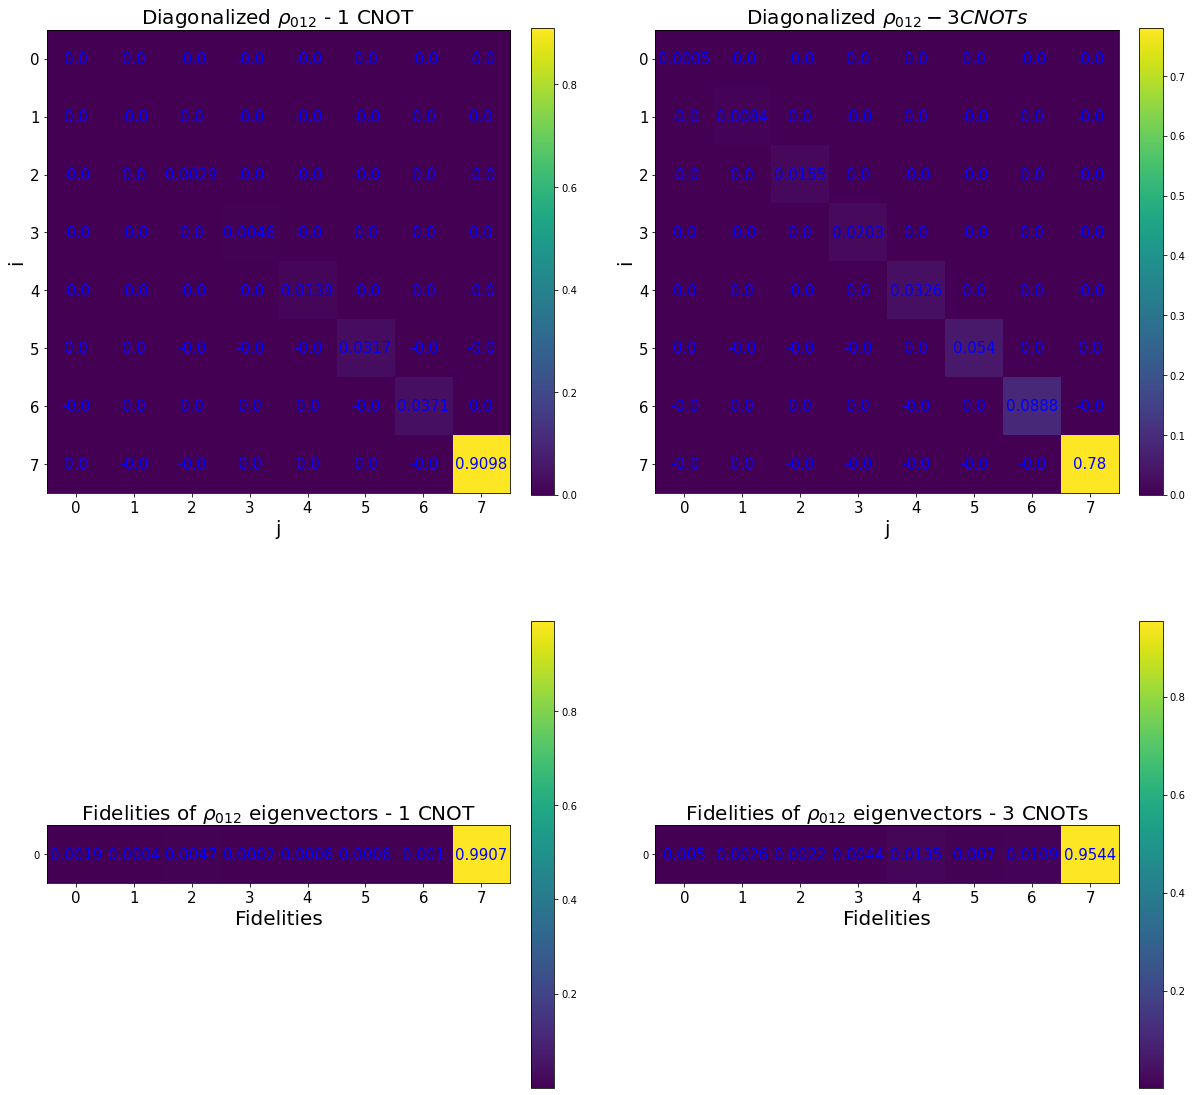

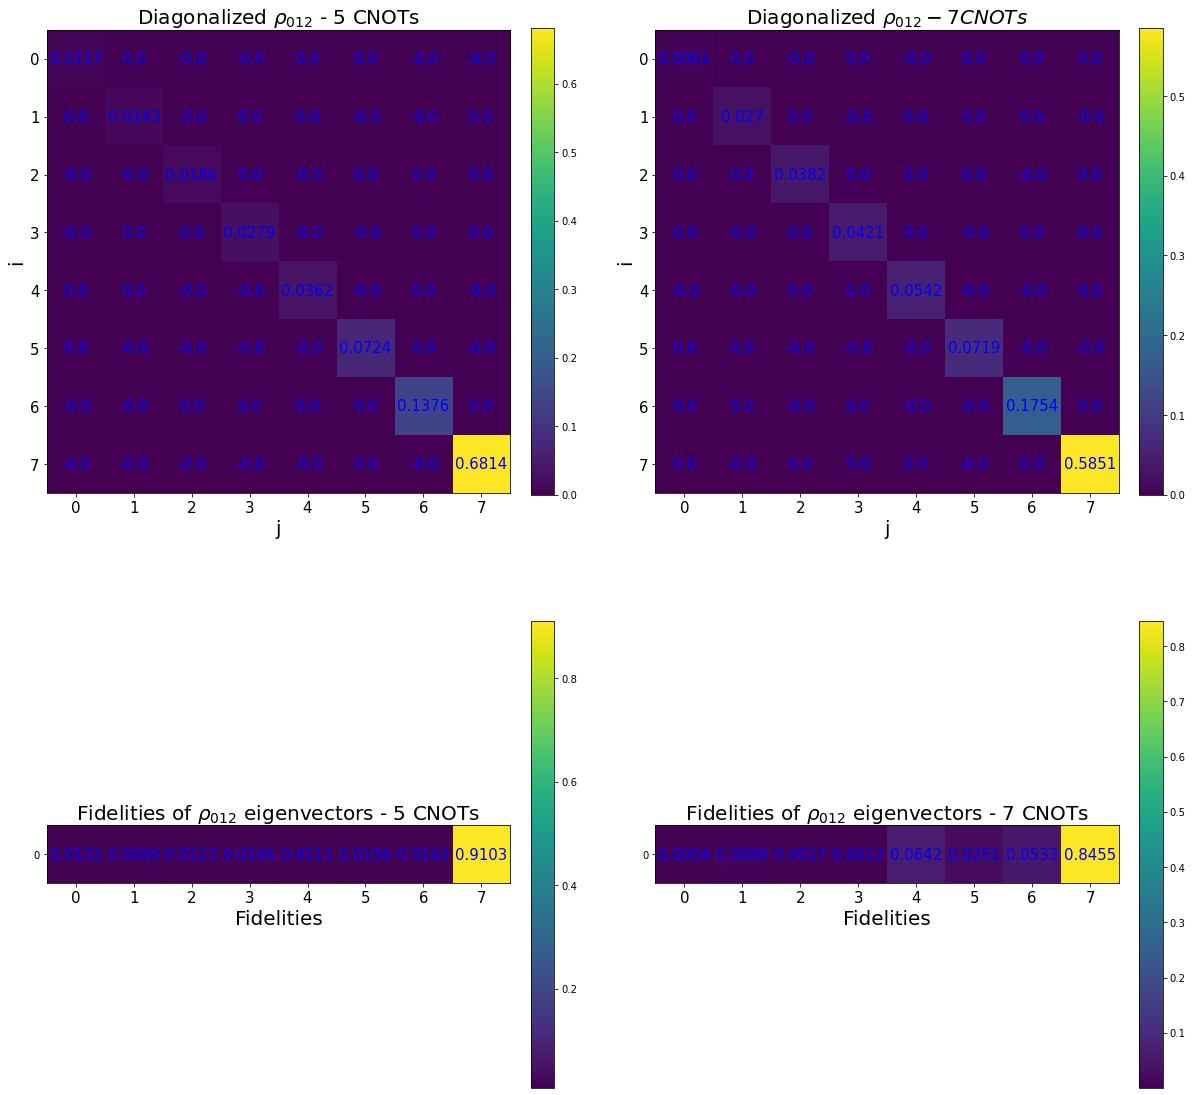

In [121]:
# Diagonalization of rho_{012} (returns eigenvalues and corresponding eigenvectors) for all #CNOTS 
e,U   = LA.eigh(rho_fit_mit)
e3,U3 = LA.eigh(rho_fit_mit3)
e5,U5   = LA.eigh(rho_fit_mit5)
e3,U7 = LA.eigh(rho_fit_mit7)

rho = np.real(np.round(np.dot(LA.inv(U),np.dot(rho_fit_mit,U)),4))
rho3 = np.real(np.round(np.dot(LA.inv(U3),np.dot(rho_fit_mit3,U3)),4))
rho5 = np.real(np.round(np.dot(LA.inv(U5),np.dot(rho_fit_mit5,U5)),4))
rho7 = np.real(np.round(np.dot(LA.inv(U7),np.dot(rho_fit_mit7,U7)),4))

########
# 1 CNOT
########

# Plots of diagonalized rho_{012}
fig, ax = plt.subplots(2,2,figsize=(20,20))
im = ax[0,0].imshow(rho)

ax[0,0].set_xticks(np.arange(len(rho)))
ax[0,0].set_yticks(np.arange(len(rho)))
ax[0,0].set_xticklabels(np.arange(len(rho)), fontsize=15)
ax[0,0].set_yticklabels(np.arange(len(rho)), fontsize=15)

ax[0,0].set_xlabel("j",fontsize=20)
ax[0,0].set_ylabel("i",fontsize=20)

plt.colorbar(im,ax=ax[0,0],orientation='vertical',fraction=0.046, pad=0.04)
for i in range(len(rho)):
    for j in range(len(rho)):
        text = ax[0,0].text(j, i, round(rho[i, j],4), ha="center", va="center", color="b", fontsize=15)
ax[0,0].set_title(r"Diagonalized $\rho_{012}$ - 1 CNOT", fontsize=20)
#fig[0,0].tight_layout()

# Fidelities of corresponding rho_{012} eigenvectors

fid = []
for i in range(len(rho)):
    fid.append(np.abs(np.dot(np.conjugate(target_state.data),U[:,i]))**2)
M_fid = []
M_fid.append(fid)
#print(M_fid)

im = ax[1,0].imshow(M_fid)

ax[1,0].set_xticks(np.arange(len(fid)))
ax[1,0].set_yticks(np.arange(1))
ax[1,0].set_xticklabels(np.arange(len(fid)), fontsize=15)
#ax.set_yticklabels(np.arange(len(rho1)), fontsize=15)

ax[1,0].set_xlabel("Fidelities",fontsize=20)
#ax.set_ylabel("i",fontsize=20)

plt.colorbar(im,ax=ax[1,0],orientation='vertical',fraction=0.046, pad=0.04)
for j in range(len(fid)):
    text = ax[1,0].text(j, 0, np.round(fid[j],4), ha="center", va="center", color="b", fontsize=15)
ax[1,0].set_title(r"Fidelities of $\rho_{012}$ eigenvectors - 1 CNOT", fontsize=20)
#fig[1,0].tight_layout()

#########
# 3 CNOTs
#########

# Plots of diagonalized rho_{012}
im = ax[0,1].imshow(rho3)

ax[0,1].set_xticks(np.arange(len(rho3)))
ax[0,1].set_yticks(np.arange(len(rho3)))
ax[0,1].set_xticklabels(np.arange(len(rho3)), fontsize=15)
ax[0,1].set_yticklabels(np.arange(len(rho3)), fontsize=15)

ax[0,1].set_xlabel("j",fontsize=20)
ax[0,1].set_ylabel("i",fontsize=20)

plt.colorbar(im,ax=ax[0,1], orientation='vertical',fraction=0.046, pad=0.04)
for i in range(len(rho3)):
    for j in range(len(rho3)):
        text = ax[0,1].text(j, i, round(rho3[i, j],4), ha="center", va="center", color="b", fontsize=15)
ax[0,1].set_title(r"Diagonalized $\rho_{012} - 3 CNOTs$", fontsize=20)
#fig[0,1].tight_layout()

# Fidelities of corresponding rho_{012} eigenvectors
fid = []
for i in range(len(rho)):
    fid.append(np.abs(np.dot(np.conjugate(target_state.data),U3[:,i]))**2)
M_fid = []
M_fid.append(fid)
#print(M_fid)

im = ax[1,1].imshow(M_fid)

ax[1,1].set_xticks(np.arange(len(fid)))
ax[1,1].set_yticks(np.arange(1))
ax[1,1].set_xticklabels(np.arange(len(fid)), fontsize=15)
#ax.set_yticklabels(np.arange(len(rho3)), fontsize=15)

ax[1,1].set_xlabel("Fidelities",fontsize=20)
#ax.set_ylabel("i",fontsize=20)

plt.colorbar(im,ax=ax[1,1] ,orientation='vertical',fraction=0.046, pad=0.04)
for j in range(len(fid)):
    text = ax[1,1].text(j, 0, np.round(fid[j],4), ha="center", va="center", color="b", fontsize=15)
ax[1,1].set_title(r"Fidelities of $\rho_{012}$ eigenvectors - 3 CNOTs", fontsize=20)
#fig[1,1].tight_layout()

plt.show()

#########
# 5 CNOTs
#########

# Plots of diagonalized rho_{012}
fig, ax = plt.subplots(2,2,figsize=(20,20))
im = ax[0,0].imshow(rho5)

ax[0,0].set_xticks(np.arange(len(rho5)))
ax[0,0].set_yticks(np.arange(len(rho5)))
ax[0,0].set_xticklabels(np.arange(len(rho5)), fontsize=15)
ax[0,0].set_yticklabels(np.arange(len(rho5)), fontsize=15)

ax[0,0].set_xlabel("j",fontsize=20)
ax[0,0].set_ylabel("i",fontsize=20)

plt.colorbar(im,ax=ax[0,0],orientation='vertical',fraction=0.046, pad=0.04)
for i in range(len(rho)):
    for j in range(len(rho)):
        text = ax[0,0].text(j, i, round(rho5[i, j],4), ha="center", va="center", color="b", fontsize=15)
ax[0,0].set_title(r"Diagonalized $\rho_{012}$ - 5 CNOTs", fontsize=20)
#fig[0,0].tight_layout()

# Fidelities of corresponding rho_{012} eigenvectors

fid = []
for i in range(len(rho5)):
    fid.append(np.abs(np.dot(np.conjugate(target_state.data),U5[:,i]))**2)
M_fid = []
M_fid.append(fid)
#print(M_fid)

im = ax[1,0].imshow(M_fid)

ax[1,0].set_xticks(np.arange(len(fid)))
ax[1,0].set_yticks(np.arange(1))
ax[1,0].set_xticklabels(np.arange(len(fid)), fontsize=15)
#ax.set_yticklabels(np.arange(len(rho1)), fontsize=15)

ax[1,0].set_xlabel("Fidelities",fontsize=20)
#ax.set_ylabel("i",fontsize=20)

plt.colorbar(im,ax=ax[1,0],orientation='vertical',fraction=0.046, pad=0.04)
for j in range(len(fid)):
    text = ax[1,0].text(j, 0, np.round(fid[j],4), ha="center", va="center", color="b", fontsize=15)
ax[1,0].set_title(r"Fidelities of $\rho_{012}$ eigenvectors - 5 CNOTs", fontsize=20)
#fig[1,0].tight_layout()

#########
# 7 CNOTs
#########

# Plots of diagonalized rho_{012}
im = ax[0,1].imshow(rho7)

ax[0,1].set_xticks(np.arange(len(rho7)))
ax[0,1].set_yticks(np.arange(len(rho7)))
ax[0,1].set_xticklabels(np.arange(len(rho7)), fontsize=15)
ax[0,1].set_yticklabels(np.arange(len(rho7)), fontsize=15)

ax[0,1].set_xlabel("j",fontsize=20)
ax[0,1].set_ylabel("i",fontsize=20)

plt.colorbar(im,ax=ax[0,1], orientation='vertical',fraction=0.046, pad=0.04)
for i in range(len(rho3)):
    for j in range(len(rho3)):
        text = ax[0,1].text(j, i, round(rho7[i, j],4), ha="center", va="center", color="b", fontsize=15)
ax[0,1].set_title(r"Diagonalized $\rho_{012} - 7 CNOTs$", fontsize=20)
#fig[0,1].tight_layout()

# Fidelities of corresponding rho_{012} eigenvectors
fid = []
for i in range(len(rho)):
    fid.append(np.abs(np.dot(np.conjugate(target_state.data),U7[:,i]))**2)
M_fid = []
M_fid.append(fid)
#print(M_fid)

im = ax[1,1].imshow(M_fid)

ax[1,1].set_xticks(np.arange(len(fid)))
ax[1,1].set_yticks(np.arange(1))
ax[1,1].set_xticklabels(np.arange(len(fid)), fontsize=15)
#ax.set_yticklabels(np.arange(len(rho7)), fontsize=15)

ax[1,1].set_xlabel("Fidelities",fontsize=20)
#ax.set_ylabel("i",fontsize=20)

plt.colorbar(im,ax=ax[1,1] ,orientation='vertical',fraction=0.046, pad=0.04)
for j in range(len(fid)):
    text = ax[1,1].text(j, 0, np.round(fid[j],4), ha="center", va="center", color="b", fontsize=15)
ax[1,1].set_title(r"Fidelities of $\rho_{012}$ eigenvectors - 7 CNOTs", fontsize=20)
#fig[1,1].tight_layout()

plt.show()

#### RE on the eigenvalues of $\rho_{012}$ (Is that possible?)

- We are not sure that the eigenvalues of each matric $\rho_{012}$ just evolve from one case to the other and the hypothesis of *Kandala et al.* inside the RE paper consider only expectation values.

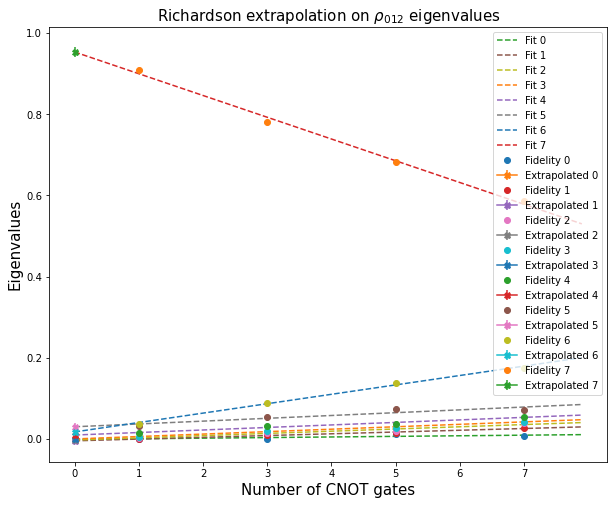

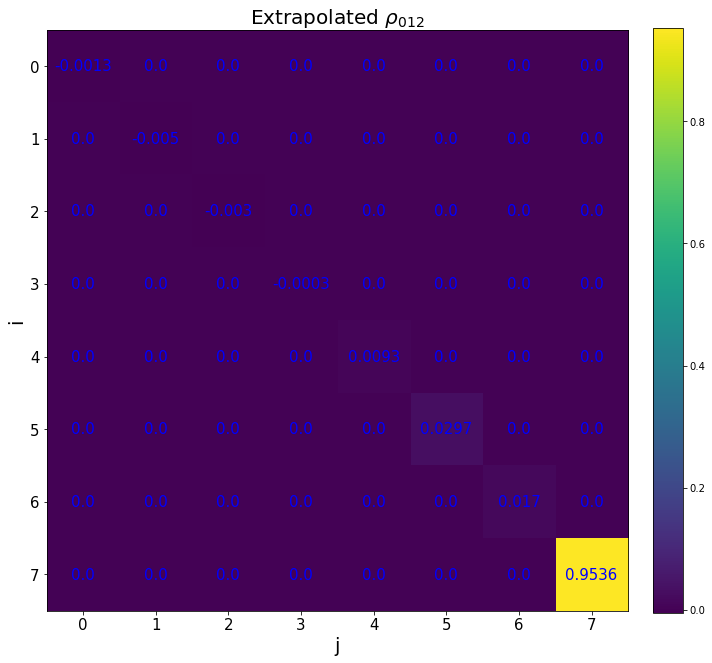

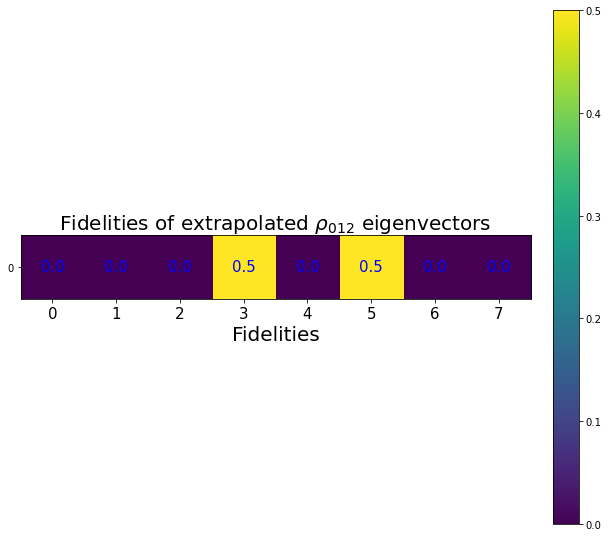

In [123]:
# Richardson extrapolation analysis
plt.figure(figsize=(10,8))
extr_eig = []
for i in range(len(rho)):
    # Data
    plt.errorbar([1,3,5,7],[rho[i,i],rho3[i,i],rho5[i,i],rho7[i,i]],marker='o',ls="none",label="Fidelity "+str(i))

    p_ave,p_cov = curve_fit(straight_line,[1,3,5,7],[rho[i,i],rho3[i,i],rho5[i,i],rho7[i,i]],absolute_sigma=False)
    # Extrapolated data
    extr_eig.append(p_ave[1])
    plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+str(i))
    u = list(np.arange(0,8,0.1))
    v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
    plt.plot(u,v,'--',label='Fit '+str(i))

plt.title(r"Richardson extrapolation on $\rho_{012}$ eigenvalues",size=15)
plt.xlabel("Number of CNOT gates",size=15)
plt.xticks(np.arange(8))
plt.ylabel("Eigenvalues",size=15)
plt.legend(loc='upper right')
plt.show()

# Extrapolated matrix of rho_{012}
rho_extr = np.zeros((8,8))
for i in range(len(rho_extr)):
    rho_extr[i,i] = extr_eig[i]

fig, ax = plt.subplots(figsize=(10,12))
im = ax.imshow(rho_extr)

ax.set_xticks(np.arange(len(rho_extr)))
ax.set_yticks(np.arange(len(rho_extr)))
ax.set_xticklabels(np.arange(len(rho_extr)), fontsize=15)
ax.set_yticklabels(np.arange(len(rho_extr)), fontsize=15)

ax.set_xlabel("j",fontsize=20)
ax.set_ylabel("i",fontsize=20)

fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)
for i in range(len(rho_extr)):
    for j in range(len(rho_extr)):
        text = ax.text(j, i, round(rho_extr[i, j],4), ha="center", va="center", color="b", fontsize=15)
ax.set_title(r"Extrapolated $\rho_{012}$", fontsize=20)
fig.tight_layout()
plt.show()


# Fidelities of extrapolated rho_{012} eigenvectors
e_extr,U_extr = LA.eigh(rho_extr)
#print(np.dot(LA.inv(U_extr),np.dot(rho_extr,U_extr)))

fid = []
for i in range(len(rho_extr)):
    fid.append(np.abs(np.dot(np.conjugate(target_state.data),U_extr[:,i]))**2)
M_fid = []
M_fid.append(fid)
#print(M_fid)

fig,ax = plt.subplots(figsize=(10,12))
im = ax.imshow(M_fid)

ax.set_xticks(np.arange(len(fid)))
ax.set_yticks(np.arange(1))
ax.set_xticklabels(np.arange(len(fid)), fontsize=15)

ax.set_xlabel("Fidelities",fontsize=20)
#ax.set_ylabel("i",fontsize=20)

plt.colorbar(im ,orientation='vertical',fraction=0.046, pad=0.04)
for j in range(len(fid)):
    text = ax.text(j, 0, np.round(fid[j],4), ha="center", va="center", color="b", fontsize=15)
ax.set_title(r"Fidelities of extrapolated $\rho_{012}$ eigenvectors", fontsize=20)
#fig.tight_layout()

plt.show()


- We notice that the dominant eigenvalue reduces when increasing the number of CNOTs, while the remaining eigenvalues increase.
 
- Only two eigenvectors of extrapolated $\rho_{012}$  have non-zero overlap with the ideal state $|\psi_{target} \rangle = | s_L=0, s=1/2, s_z = -1/2 \rangle$.

### Fidelities and purities for all CG circuits

#### Target states

In [26]:
target_state = []
for l in lab_list:
    circ3    = QuantumCircuit(nqubits)

    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

    circ3.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

    if l[0]==0:
        circ3.cx(1,0)
        circ3.ch(1,0)
        # Alternative way to create a controlled-Hadamard
        #c_gate = HGate().control(1)
        #circ3.append(c_gate,[1,0])
        circ3.cx(1,2)

    elif l[0]==1:
        if l[2]+0.5==0:
            circ3.ch(1,0)
            circ3.cx(1,2)
        elif l[2]+0.5==-1:
            circ3.cx(1,0)

    circ3.x(1)

    if l[0]==0:
        circ3.cx(1,0)
        circ3.ch(1,0)
        circ3.cx(1,2)

    elif l[0]==1:
        if l[2]-0.5==0:
            circ3.ch(1,0)
            circ3.cx(1,2)
        elif l[2]-0.5==-1:
            circ3.cx(1,0)

    circ3.x(1)
    circ3.cx(0,2)

    # Target state associated to the circuit on th first three qubits
    target_state.append(qiskit.quantum_info.Statevector.from_instruction(circ3))

#### Plots

Circuit associated with  (0, 0.5, -0.5)
              ┌───┐┌───┐          ┌───┐┌───┐               
q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──
     ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  
q_1: ┤ RY(π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──
     └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐
q_2: ───────────────────┤ X ├───────────────┤ X ├─────┤ X ├
                        └───┘               └───┘     └───┘
q_3: ──────────────────────────────────────────────────────
                                                           
q_4: ──────────────────────────────────────────────────────
                                                           
#CNOT = 1 - State fidelity (w/ correction): F = 0.90192
#CNOT = 3 - State fidelity (w/ correction): F = 0.79527
#CNOT = 5 - State fidelity (w/ correction): F = 0.71159
#CNOT = 7 - State fidelity (w/ correction): F = 0.53739


#CNOT = 1 - Purity of rho_{012} =  (0.8254649421517947+0j)
#CNOT = 3 - Pur

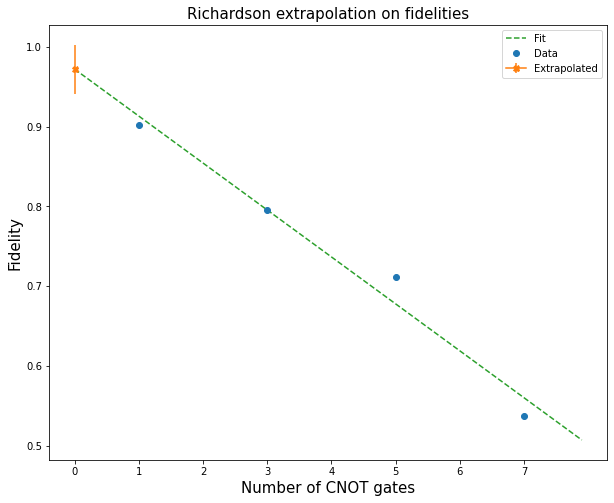

Extrapolated fidelity: 0.9719988190690462 +/- 0.03061344385701182
Circuit associated with  (0, 0.5, 0.5)
              ┌───┐┌───┐          ┌───┐┌───┐               
q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──
     ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  
q_1: ┤ RY(0) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──
     └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐
q_2: ───────────────────┤ X ├───────────────┤ X ├─────┤ X ├
                        └───┘               └───┘     └───┘
q_3: ──────────────────────────────────────────────────────
                                                           
q_4: ──────────────────────────────────────────────────────
                                                           
#CNOT = 1 - State fidelity (w/ correction): F = 0.89976
#CNOT = 3 - State fidelity (w/ correction): F = 0.82112
#CNOT = 5 - State fidelity (w/ correction): F = 0.71902
#CNOT = 7 - State fidelity (w/ correction): F = 0.62958


#CNOT = 1

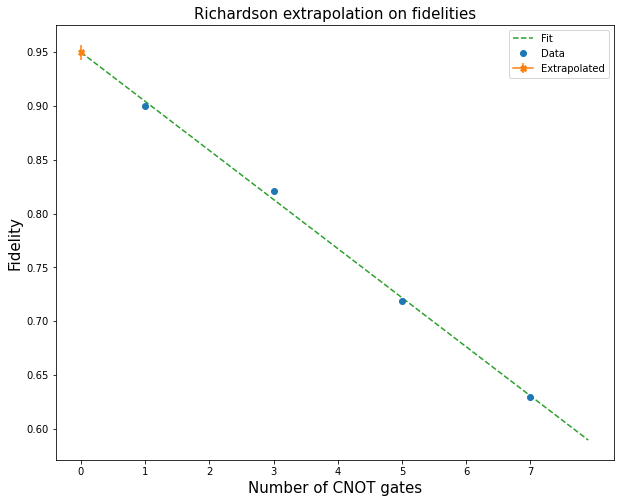

Extrapolated fidelity: 0.9498971406971405 +/- 0.007040392349199381
Circuit associated with  (1, 0.5, -0.5)
                   ┌───┐          ┌───┐          
q_0: ──────────────┤ H ├──────────┤ X ├───────■──
     ┌────────────┐└─┬─┘     ┌───┐└─┬─┘┌───┐  │  
q_1: ┤ RY(5.0522) ├──■────■──┤ X ├──■──┤ X ├──┼──
     └────────────┘     ┌─┴─┐└───┘     └───┘┌─┴─┐
q_2: ───────────────────┤ X ├───────────────┤ X ├
                        └───┘               └───┘
q_3: ────────────────────────────────────────────
                                                 
q_4: ────────────────────────────────────────────
                                                 
#CNOT = 1 - State fidelity (w/ correction): F = 0.91086
#CNOT = 3 - State fidelity (w/ correction): F = 0.76434
#CNOT = 5 - State fidelity (w/ correction): F = 0.61498
#CNOT = 7 - State fidelity (w/ correction): F = 0.49785


#CNOT = 1 - Purity of rho_{012} =  (0.8466441903612081+0j)
#CNOT = 3 - Purity of rho_{012} =  (0.7011053496354271+0j)

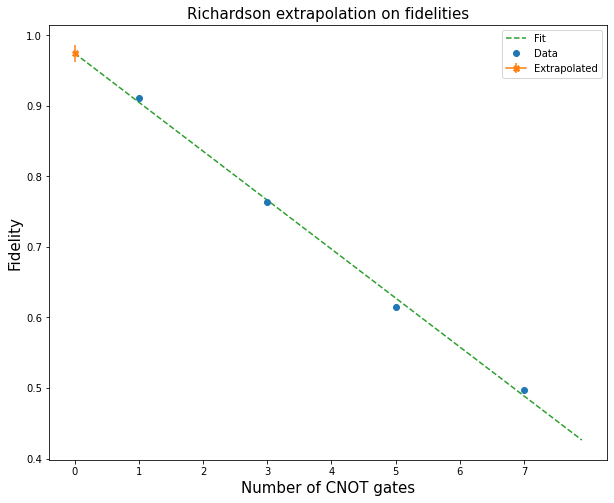

Extrapolated fidelity: 0.9746843846480361 +/- 0.012071962289911392
Circuit associated with  (1, 0.5, 0.5)
                        ┌───┐               
q_0: ───────────────────┤ H ├────────────■──
     ┌────────────┐┌───┐└─┬─┘     ┌───┐  │  
q_1: ┤ RY(4.3726) ├┤ X ├──■────■──┤ X ├──┼──
     └────────────┘└───┘     ┌─┴─┐└───┘┌─┴─┐
q_2: ────────────────────────┤ X ├─────┤ X ├
                             └───┘     └───┘
q_3: ───────────────────────────────────────
                                            
q_4: ───────────────────────────────────────
                                            
#CNOT = 1 - State fidelity (w/ correction): F = 0.91542
#CNOT = 3 - State fidelity (w/ correction): F = 0.85698
#CNOT = 5 - State fidelity (w/ correction): F = 0.76234
#CNOT = 7 - State fidelity (w/ correction): F = 0.66787


#CNOT = 1 - Purity of rho_{012} =  (0.86636319497668+0j)
#CNOT = 3 - Purity of rho_{012} =  (0.7807201256430883+0j)
#CNOT = 5 - Purity of rho_{012} =  (0.6372244839216461+0j

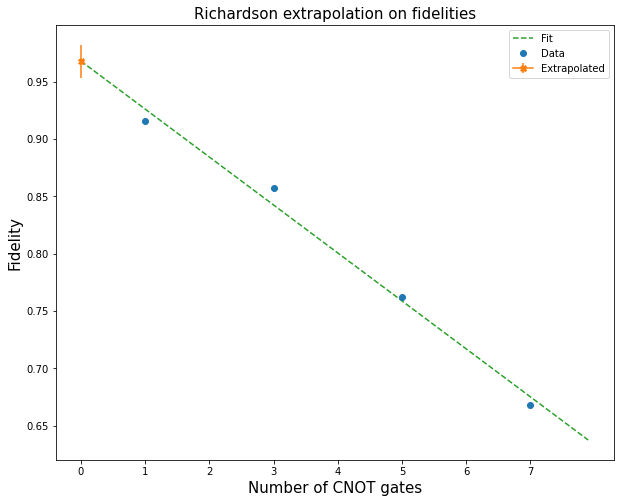

Extrapolated fidelity: 0.9681169827648717 +/- 0.01432284041012299
Circuit associated with  (1, 1.5, -1.5)
              ┌───┐               
q_0: ─────────┤ X ├───────■───────
     ┌───────┐└─┬─┘┌───┐  │  ┌───┐
q_1: ┤ RY(π) ├──■──┤ X ├──┼──┤ X ├
     └───────┘     └───┘┌─┴─┐└───┘
q_2: ───────────────────┤ X ├─────
                        └───┘     
q_3: ─────────────────────────────
                                  
q_4: ─────────────────────────────
                                  
#CNOT = 1 - State fidelity (w/ correction): F = 0.95184
#CNOT = 3 - State fidelity (w/ correction): F = 0.91192
#CNOT = 5 - State fidelity (w/ correction): F = 0.88231
#CNOT = 7 - State fidelity (w/ correction): F = 0.86508


#CNOT = 1 - Purity of rho_{012} =  (0.9107668363493098+0j)
#CNOT = 3 - Purity of rho_{012} =  (0.8406274164576546+0j)
#CNOT = 5 - Purity of rho_{012} =  (0.7930051436268947+0j)
#CNOT = 7 - Purity of rho_{012} =  (0.7603718086311938+0j)


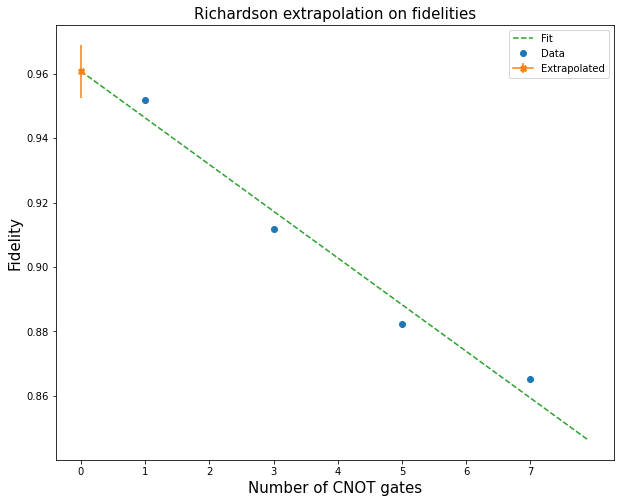

Extrapolated fidelity: 0.9607668752616294 +/- 0.008230177762418496
Circuit associated with  (1, 1.5, -0.5)
                   ┌───┐          ┌───┐          
q_0: ──────────────┤ H ├──────────┤ X ├───────■──
     ┌────────────┐└─┬─┘     ┌───┐└─┬─┘┌───┐  │  
q_1: ┤ RY(1.9106) ├──■────■──┤ X ├──■──┤ X ├──┼──
     └────────────┘     ┌─┴─┐└───┘     └───┘┌─┴─┐
q_2: ───────────────────┤ X ├───────────────┤ X ├
                        └───┘               └───┘
q_3: ────────────────────────────────────────────
                                                 
q_4: ────────────────────────────────────────────
                                                 
#CNOT = 1 - State fidelity (w/ correction): F = 0.91540
#CNOT = 3 - State fidelity (w/ correction): F = 0.77505
#CNOT = 5 - State fidelity (w/ correction): F = 0.61593
#CNOT = 7 - State fidelity (w/ correction): F = 0.46643


#CNOT = 1 - Purity of rho_{012} =  (0.8528711464660415+0j)
#CNOT = 3 - Purity of rho_{012} =  (0.7184576532831245+0j)

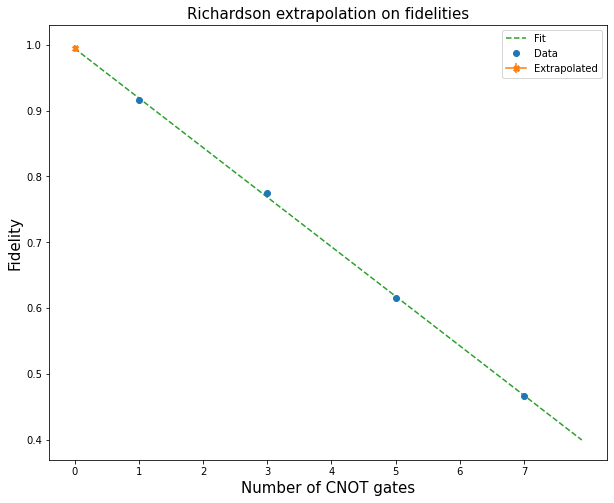

Extrapolated fidelity: 0.9944075485456916 +/- 0.005668285671283751
Circuit associated with  (1, 1.5, 0.5)
                       ┌───┐               
q_0: ──────────────────┤ H ├────────────■──
     ┌───────────┐┌───┐└─┬─┘     ┌───┐  │  
q_1: ┤ RY(1.231) ├┤ X ├──■────■──┤ X ├──┼──
     └───────────┘└───┘     ┌─┴─┐└───┘┌─┴─┐
q_2: ───────────────────────┤ X ├─────┤ X ├
                            └───┘     └───┘
q_3: ──────────────────────────────────────
                                           
q_4: ──────────────────────────────────────
                                           
#CNOT = 1 - State fidelity (w/ correction): F = 0.90269


IBMQBackendApiError: 'Error submitting job: "(\'Connection aborted.\', ConnectionResetError(54, \'Connection reset by peer\'))"'

In [11]:
s = 8192
for il,l in enumerate(lab_list):
    ################################
    # Definition of the circuit
    ################################

    circ    = QuantumCircuit(5)

    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

    circ.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        # Alternative way to create a controlled-Hadamard
        #c_gate = HGate().control(1)
        #circ.append(c_gate,[1,0])
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]+0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]+0.5==-1:
            circ.cx(1,0)

    circ.x(1)

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]-0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]-0.5==-1:
            circ.cx(1,0)

    circ.x(1)
    circ.cx(0,2)
    print("Circuit associated with ",l)
    print(circ.draw())

    ###################
    # NO MULTIPLICATION
    ###################

    # Generate the state tomography circuit
    tomo_circ = state_tomography_circuits(circ,[0,1,2])

    # Execute
    job = qiskit.execute(tomo_circ, device, shots=8192)

    # Generate the calibration circuits (Readout Error Mitigation)
    meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1,2])

    job_cal = qiskit.execute(meas_calibs, device, shots=8192)
    meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

    # WITH READOUT ERROR MITIGATION
    correct_tomo_results = meas_fitter.filter.apply(job.result(), method='least_squares')
    tomo_mit = StateTomographyFitter(correct_tomo_results, tomo_circ)
    rho_fit_mit = tomo_mit.fit(method='lstsq')
    fid_mit = qiskit.quantum_info.state_fidelity(rho_fit_mit, target_state[il])
    print('#CNOT = 1 - State fidelity (w/ correction): F = {:.5f}'.format(fid_mit))

    # Hardware + measurement error mitigation + Richardson extrapolation

    ######################################
    # CIRCUIT for RE - MULTIPLICATION BY 3
    ######################################

    circ_R = QuantumCircuit(5)

    for g in circ: # loop over gates in circ
        instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
        #print(instruction.name)
        if(instruction.name=='cx'): # if cnot, replicate
            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
        elif(instruction.name=='u3'): # if u3, copy and paste
            t1,t2,t3 = instruction.params
            circ_R.u3(t1,t2,t3,qubits[0])
        elif(instruction.name=='x'):
            circ_R.x(qubits[0])
        elif(instruction.name=='ry'): # if ry, copy and paste
            t1 = instruction.params[0]
            circ_R.ry(t1,qubits[0])
        elif(instruction.name=='ch'):
            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
        #else:
        #    print("!!! ",instruction)

    #print(circ_R.draw())

    # Generate the state tomography circuit
    tomo_circ3 = state_tomography_circuits(circ_R,[0,1,2])

    # Execute
    job3 = qiskit.execute(tomo_circ3, device, shots=8192)

    # Generate the calibration circuits (Readout Error Mitigation)
    meas_calibs3, state_labels3 = mc.complete_meas_cal(qubit_list=[0,1,2])

    job_cal3 = qiskit.execute(meas_calibs3, device, shots=8192)
    meas_fitter3 = mc.CompleteMeasFitter(job_cal3.result(),state_labels3)

    # WITH READOUT ERROR MITIGATION
    correct_tomo_results3 = meas_fitter3.filter.apply(job3.result(), method='least_squares')
    tomo_mit3 = StateTomographyFitter(correct_tomo_results3, tomo_circ3)
    rho_fit_mit3 = tomo_mit3.fit(method='lstsq')
    fid_mit3 = qiskit.quantum_info.state_fidelity(rho_fit_mit3, target_state[il])
    print('#CNOT = 3 - State fidelity (w/ correction): F = {:.5f}'.format(fid_mit3))

    ######################################
    # CIRCUIT for RE - MULTIPLICATION BY 5
    ######################################

    circ_R  = QuantumCircuit(5)

    for g in circ: # loop over gates in circ
        instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
        #print(instruction.name)
        if(instruction.name=='cx'): # if cnot, replicate
            for k in range(5):
                circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
        elif(instruction.name=='u3'): # if u3, copy and paste
            t1,t2,t3 = instruction.params
            circ_R.u3(t1,t2,t3,qubits[0])
        elif(instruction.name=='x'):
            circ_R.x(qubits[0])
        elif(instruction.name=='ry'): # if ry, copy and paste
            t1 = instruction.params[0]
            circ_R.ry(t1,qubits[0])
        elif(instruction.name=='ch'):
            for k in range(5):
                circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
        else:
            print("!!! ",instruction)

    #print(circ_R.draw())

    # Generate the state tomography circuit
    tomo_circ5 = state_tomography_circuits(circ_R,[0,1,2])

    # Execute
    job5 = qiskit.execute(tomo_circ5, device, shots=8192)

    # Generate the calibration circuits (Readout Error Mitigation)
    meas_calibs5, state_labels5 = mc.complete_meas_cal(qubit_list=[0,1,2])

    job_cal5 = qiskit.execute(meas_calibs5, device, shots=8192)
    meas_fitter5 = mc.CompleteMeasFitter(job_cal5.result(),state_labels5)

    # WITH READOUT ERROR MITIGATION
    correct_tomo_results5 = meas_fitter5.filter.apply(job5.result(), method='least_squares')
    tomo_mit5 = StateTomographyFitter(correct_tomo_results5, tomo_circ5)
    rho_fit_mit5 = tomo_mit5.fit(method='lstsq')
    fid_mit5 = qiskit.quantum_info.state_fidelity(rho_fit_mit5, target_state[il])
    print('#CNOT = 5 - State fidelity (w/ correction): F = {:.5f}'.format(fid_mit5))

    ######################################
    # CIRCUIT for RE - MULTIPLICATION BY 7
    ######################################

    circ_R  = QuantumCircuit(5)

    for g in circ: # loop over gates in circ
        instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
        #print(instruction.name)
        if(instruction.name=='cx'): # if cnot, replicate
            for k in range(7):
                circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
        elif(instruction.name=='u3'): # if u3, copy and paste
            t1,t2,t3 = instruction.params
            circ_R.u3(t1,t2,t3,qubits[0])
        elif(instruction.name=='x'):
            circ_R.x(qubits[0])
        elif(instruction.name=='ry'): # if ry, copy and paste
            t1 = instruction.params[0]
            circ_R.ry(t1,qubits[0])
        elif(instruction.name=='ch'):
            for k in range(7):
                circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
        else:
            print("!!! ",instruction)

    #print(circ_R.draw())

    # Generate the state tomography circuit
    tomo_circ7 = state_tomography_circuits(circ_R,[0,1,2])

    # Execute
    job7 = qiskit.execute(tomo_circ7, device, shots=8192)

    # Generate the calibration circuits (Readout Error Mitigation)
    meas_calibs7, state_labels7 = mc.complete_meas_cal(qubit_list=[0,1,2])

    job_cal7 = qiskit.execute(meas_calibs7, device, shots=8192)
    meas_fitter7 = mc.CompleteMeasFitter(job_cal7.result(),state_labels7)

    # WITH READOUT ERROR MITIGATION
    correct_tomo_results7 = meas_fitter7.filter.apply(job7.result(), method='least_squares')
    tomo_mit7 = StateTomographyFitter(correct_tomo_results7, tomo_circ7)
    rho_fit_mit7 = tomo_mit7.fit(method='lstsq')
    fid_mit7 = qiskit.quantum_info.state_fidelity(rho_fit_mit7, target_state[il])
    print('#CNOT = 7 - State fidelity (w/ correction): F = {:.5f}'.format(fid_mit7))
    
    print("\n")
    print("#CNOT = 1 - Purity of rho_{012} = ", qiskit.quantum_info.purity(rho_fit_mit))
    print("#CNOT = 3 - Purity of rho_{012} = ", qiskit.quantum_info.purity(rho_fit_mit3))
    print("#CNOT = 5 - Purity of rho_{012} = ", qiskit.quantum_info.purity(rho_fit_mit5))
    print("#CNOT = 7 - Purity of rho_{012} = ", qiskit.quantum_info.purity(rho_fit_mit7))
    
    ##########################################
    # Plot - Richardson extrapolation analysis
    ##########################################
    
    plt.figure(figsize=(10,8))
    # Data
    plt.errorbar([1,3,5,7],[fid_mit,fid_mit3,fid_mit5,fid_mit7],marker='o',ls="none",label="Data")
    # Extrapolated data
    p_ave,p_cov = curve_fit(straight_line,[1,3,5,7],[fid_mit,fid_mit3,fid_mit5,fid_mit7],absolute_sigma=False)
    plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated')
    # Fit
    u = list(np.arange(0,8,0.1))
    v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
    plt.plot(u,v,'--',label='Fit ')

    plt.title("Richardson extrapolation on fidelities",size=15)
    plt.xlabel("Number of CNOT gates",size=15)
    plt.xticks(np.arange(8))
    plt.ylabel("Fidelity",size=15)
    plt.legend()
    plt.show()

    print("Extrapolated fidelity: {} +/- {}".format(p_ave[1],np.sqrt(p_cov[1,1])))

### States: $|s_{01}=0,s=1/2,s_z=-1/2 \rangle$ and $|s_{01}=1,s=3/2,s_z=-1/2 \rangle$

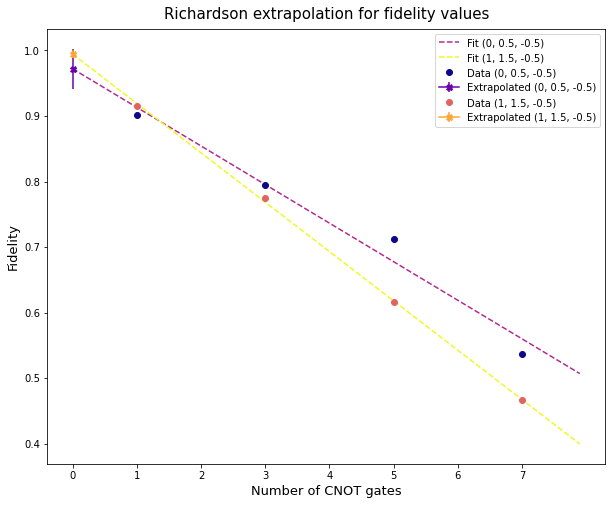

In [10]:
y = [[0.90192, 0.79527, 0.71159, 0.53739], [0.91540, 0.77505, 0.61593, 0.46643]]

jet = plt.get_cmap('plasma')
colors = iter(jet(np.linspace(0,1,6)))
labels = [(0,0.5,-0.5),(1,1.5,-0.5)]

plt.figure(figsize=(10,8))
for i in range(2):
    # Data
    plt.errorbar([1,3,5,7],y[i],marker='o',ls="none",label="Data "+str(labels[i]), color=next(colors))
    # Extrapolated data
    p_ave,p_cov = curve_fit(straight_line,[1,3,5,7],y[i],absolute_sigma=False)
    plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+str(labels[i]), color=next(colors))
    # Fit
    u = list(np.arange(0,8,0.1))
    v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
    plt.plot(u,v,'--',label='Fit '+str(labels[i]), color=next(colors))

    plt.title("Richardson extrapolation for fidelity values",size=15, pad=10)
    plt.xlabel("Number of CNOT gates",size=13)
    plt.xticks(np.arange(8))
    plt.ylabel("Fidelity",size=13)
    plt.legend()
    plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/CG_fid_3.pdf")

### B) Comparison when the last $2$ qubits are:  $|0 \rangle_3 | 0 \rangle_4$, $|1 \rangle_3 | 1 \rangle_4$ and $|+\rangle_3 |+\rangle_4$

We run on `qasm_simulator` (without noise model) and `ibmq_athens` the state tomography of the circuits with readout error mitigation and we are going to compare the results.

In [12]:
##################################
# Definition of the target circuit
##################################
l = lab_list[0]
s = 8192      # Number of shots

circ3    = QuantumCircuit(nqubits)

# theta gives the angle to use in the Ry Gate
theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

circ3.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

if l[0]==0:
    circ3.cx(1,0)
    circ3.ch(1,0)
    # Alternative way to create a controlled-Hadamard
    #c_gate = HGate().control(1)
    #circ3.append(c_gate,[1,0])
    circ3.cx(1,2)

elif l[0]==1:
    if l[2]+0.5==0:
        circ3.ch(1,0)
        circ3.cx(1,2)
    elif l[2]+0.5==-1:
        circ3.cx(1,0)

circ3.x(1)

if l[0]==0:
    circ3.cx(1,0)
    circ3.ch(1,0)
    circ3.cx(1,2)

elif l[0]==1:
    if l[2]-0.5==0:
        circ3.ch(1,0)
        circ3.cx(1,2)
    elif l[2]-0.5==-1:
        circ3.cx(1,0)

circ3.x(1)
circ3.cx(0,2)

# Target state associated to the circuit on th first three qubits
target_state = qiskit.quantum_info.Statevector.from_instruction(circ3)

rho_fit_mit   = [[] for i in range(3)]
rho_fit_mit2  = [[] for i in range(3)]

for i in range(3):    # Selection of the three possibilities of the last 2 qubits
    
    ################################
    # Definition of the circuits
    ################################
    circ = QuantumCircuit(5)

    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

    circ.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        # Alternative way to create a controlled-Hadamard
        #c_gate = HGate().control(1)
        #circ.append(c_gate,[1,0])
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]+0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]+0.5==-1:
            circ.cx(1,0)

    circ.x(1)

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]-0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]-0.5==-1:
            circ.cx(1,0)

    circ.x(1)
    circ.cx(0,2)
    
    if i == 1:
        circ.x(3)          
        circ.x(4)
    if i == 2:
        circ.h(3)
        circ.h(4)
    print("Circuit associated with state ",lab_list[0]," on 5 qubits")
    print(circ.draw())
    
    for j in range(2):      # Selection of the three possible backends
        
        if j == 0:
            print("QASM RESULTS","\n")
            backend = Aer.get_backend("qasm_simulator")
        if j == 1:
            print("HARDWARE RESULTS (ibmq_athens)","\n")
            backend = device
            
        ################################
        # Analysis of the first 3 qubits
        ################################

        # Generate the state tomography circuit
        tomo_circ = state_tomography_circuits(circ,[0,1,2])
        # Execute
        job = qiskit.execute(tomo_circ, backend, shots=8192)
        # Generate the calibration circuits (Readout Error Mitigation)
        meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1,2])
        job_cal = qiskit.execute(meas_calibs, backend, shots=8192)
        meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

        correct_tomo_results = meas_fitter.filter.apply(job.result(), method='least_squares')
        tomo_mit = StateTomographyFitter(correct_tomo_results, tomo_circ)
        rho_fit_mit[i].append(tomo_mit.fit(method='lstsq'))  
        fid_mit = qiskit.quantum_info.state_fidelity(rho_fit_mit[i][j], target_state)
        print('First 3 qubits - State fidelity (with readout error mitigation): F = {:.5f}'.format(fid_mit))

        ################################
        # Analysis of the last 2 qubits
        ################################

        # Target state for the last two qubits
        qc = QuantumCircuit(2)
        if i == 1:
            qc.x([0,1])
        if i == 2:
            qc.h([0,1])
        target_state2 = qiskit.quantum_info.Statevector.from_instruction(qc)
        #print(target_state2)

        # Generate the state tomography circuit
        tomo_circ2 = state_tomography_circuits(circ,[3,4])
        # Execute
        job2 = qiskit.execute(tomo_circ2, backend, shots=8192)
        # Fit result
        tomo_fitter2 = StateTomographyFitter(job2.result(), tomo_circ2)
        # Generate the calibration circuits (Readout Error Mitigation)
        meas_calibs2, state_labels2 = mc.complete_meas_cal(qubit_list=[3,4])
        job_cal2 = qiskit.execute(meas_calibs2, backend, shots=8192)
        meas_fitter2 = mc.CompleteMeasFitter(job_cal.result(),state_labels2)

        correct_tomo_results2 = meas_fitter2.filter.apply(job2.result(), method='least_squares')
        tomo_mit2 = StateTomographyFitter(correct_tomo_results2, tomo_circ2)
        rho_fit_mit2[i].append(tomo_mit2.fit(method='lstsq'))
        fid_mit2 = qiskit.quantum_info.state_fidelity(rho_fit_mit2[i][j], target_state2)
        print('Last 2 qubits - State fidelity (with readout error mitigation): F = {:.5f}'.format(fid_mit2),"\n")

Circuit associated with state  (0, 0.5, -0.5)  on 5 qubits
              ┌───┐┌───┐          ┌───┐┌───┐               
q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──
     ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  
q_1: ┤ RY(π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──
     └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐
q_2: ───────────────────┤ X ├───────────────┤ X ├─────┤ X ├
                        └───┘               └───┘     └───┘
q_3: ──────────────────────────────────────────────────────
                                                           
q_4: ──────────────────────────────────────────────────────
                                                           
QASM RESULTS 

First 3 qubits - State fidelity (with readout error mitigation): F = 0.99303
Last 2 qubits - State fidelity (with readout error mitigation): F = 0.99779 

HARDWARE RESULTS (ibmq_athens) 

First 3 qubits - State fidelity (with readout error mitigation): F = 0.91989
L

On the base of the initialization of the last $2$ qubits, we will refer to previous three cases with $\rho^{(00)}$, $\rho^{(11)}$ and $\rho^{(++)}$. Those density matrices are Hermitian. We can evaluate the trace distance between them. Given two Hermitian matrices $\rho$ and $\sigma$:

$T(\rho,\sigma) = \frac{1}{2}\text{Tr} \Bigl( \sqrt{(\rho - \sigma)^2}\Bigr) = \frac{1}{2} \sum_i |\lambda_i|$

where $\lambda_i$ are the eigenvalues of the Hermitian, but not necessarily positive, matrix $(\rho - \sigma)$.

In [16]:
for j in range(2):
    if j == 0:
        print("QASM RESULTS")
    else:
        print("HARDWARE RESULTS (ibmq_athens)")
        
    rho_01 = np.add(rho_fit_mit[0][j],np.dot(-1,rho_fit_mit[1][j]))
    rho_0p = np.add(rho_fit_mit[0][j],np.dot(-1,rho_fit_mit[2][j]))
    rho_1p = np.add(rho_fit_mit[1][j],np.dot(-1,rho_fit_mit[2][j]))

    e01,_ = LA.eigh(rho_01)
    e0p,_ = LA.eigh(rho_0p)
    e1p,_ = LA.eigh(rho_1p)

    t01 = 0
    for el in e01:
        t01 += np.abs(el)
    t01 = t01*0.5

    t0p = 0
    for el in e0p:
        t0p += np.abs(el)
    t0p = t01*0.5

    t1p = 0
    for el in e1p:
        t1p += np.abs(el)
    t1p = t01*0.5

    print("Trace distance rho^(00) - rho^(11): ",t01)
    print("Trace distance rho^(00) - rho^(pp): ",t0p)
    print("Trace distance rho^(11) - rho^(pp): ",t1p)

    '''
    if np.all(np.round(rho_fit_mit_11,3) == np.round(rho_fit_mit_11,3)):
        print("Equal")
    '''

QASM RESULTS
Trace distance rho^(00) - rho^(11):  0.01480794245975528
Trace distance rho^(00) - rho^(pp):  0.00740397122987764
Trace distance rho^(11) - rho^(pp):  0.00740397122987764
HARDWARE RESULTS (ibmq_athens)
Trace distance rho^(00) - rho^(11):  0.038234067735692955
Trace distance rho^(00) - rho^(pp):  0.019117033867846477
Trace distance rho^(11) - rho^(pp):  0.019117033867846477


From an exact analysis without noise we should expect that the density matrices associated with the three circuits are all equal (trace distance equal to $0$). We notice both from the `qasm_simulation` and `ibmq_athens` results that the trace distances strongly depend on the geometry of the states considered.

<img src="Pictures/Blochsphere.jpeg" width="400">

**Question** Is this another proof of the cross-talking between the frist three qubits and the last two?

## Alternative mitigation procedures

First of all, the following two mitigation methods, **CTMP** and **Tensored**, are not supported by the `measurement_error_mitigation_cls` paramter of the `QuantumInstance`. 

In order to compute the expectation values inside the following code we use the `expectation_value` function of Qiskit. In particular we have to express the expectation value of a given operator $O$ on the state $|\psi \rangle$ as:

$$\langle \psi | O | \psi \rangle = \langle \psi | U^\dagger \Lambda U | \psi \rangle$$

We build the circuit associated with $U |\psi \rangle$ and then we compute the expectation value using the diagonalized matrix $\Lambda$. We start from computing the matrices $U$ associated to $S_{02}^2$, $S^2$ and $S_z$.

In [10]:
e,U = [],[]
e.append(LA.eigh(op_s022.to_matrix())[0])
U.append(LA.eigh(op_s022.to_matrix())[1])
e.append(LA.eigh(op_s2.to_matrix())[0])
U.append(LA.eigh(op_s2.to_matrix())[1])
e.append(LA.eigh(op_sz.to_matrix())[0])
U.append(LA.eigh(op_sz.to_matrix())[1])

## Continuous-time Markov Process (CTMP) mitigation

**References:** https://medium.com/qiskit/mitigate-qubit-measurement-errors-in-qiskit-using-this-new-technique-1bb07ec319b5 

**Qiskit info:**
- https://qiskit.org/documentation/stubs/qiskit.ignis.mitigation.expval_meas_mitigator_circuits.html
- https://qiskit.org/documentation/stubs/qiskit.ignis.mitigation.expectation_value.html#qiskit.ignis.mitigation.expectation_value

We want to mitigate the error using the CTMP method. As an **example**, consider what happens for a **single qubit**: if we perform a measurement on a basis state of 0 or 1, the ideal measurement always returns 0 or 1, respectively. However, **noise can induce unwanted transitions between 0 and 1**. We can describe the effect of such classical noise using a $2 \times 2$ matrix of transition probabilities. The two off-diagonal elements of the noise matrix (that is, the upper right and lower left elements), specify the probability of unwanted transitions from 0 to 1 and vice versa. We can estimate all entries of the noise matrix by counting how often each unwanted transition happens in the experiment. Finally, we can mitigate the errors by applying the inverse of this matrix to the noisy measurement outcomes. But there’s a challenge: as the number of qubits $n$ grows, the number of unwanted transitions and size of the noise matrix grow exponentially. So instead of a two-by-two matrix, we have to look at a $2^n \times 2^n$ matrix. Essentially, you’d have to run an unfeasible number of experiments in order to compare expected versus actual outcomes and calculate the probabilities.

Here we define the expected the calibration circuits for the CTMP method.

In [24]:
import qiskit.ignis.mitigation as mit

# READOUT ERROR MITIGATION with flag: measurement_error_mitigation_cls = CompleteMeasFitter
instance = QuantumInstance(backend                          = device,
                           shots                            = 8192,
                           coupling_map                     = device.configuration().coupling_map,
                           optimization_level               = 3,
                           initial_layout                   = [0,1,2])

# Generate calibration circuits
cal_circs, metadata = mit.expval_meas_mitigator_circuits(3, method='CTMP')
result = instance.execute(cal_circs)
# Fit mitigator
mitigator = mit.ExpvalMeasMitigatorFitter(result,metadata).fit()

# Plot fitted N-qubit assignment matrix
#mitigator.plot_assignment_matrix()

We use the device: `ibmq_athens`.

In [114]:
res_raw,res_CTMP = [],[]

for i in range(3):
    l = lab_list[0]
    circ = QuantumCircuit(3)

    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

    circ.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        # Alternative way to create a controlled-Hadamard
        #c_gate = HGate().control(1)
        #circ.append(c_gate,[1,0])
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]+0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]+0.5==-1:
            circ.cx(1,0)

    circ.x(1)

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]-0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]-0.5==-1:
            circ.cx(1,0)

    circ.x(1)
    circ.cx(0,2)
    #print("Circuit associated with (0,1/2,-1/2)")
    #print(circ.draw())

    from qiskit.aqua.operators.converters import PauliBasisChange

    circ.unitary(U[i],[0,1,2])
    circ.measure_all()
    if i==0:
        print(circ.draw())
    
    instance = QuantumInstance(backend                          = device,
                               shots                            = 8192,
                               coupling_map                     = device.configuration().coupling_map,
                               optimization_level               = 3,
                               initial_layout                   = [0,1,2])

    
    #instance = QuantumInstance(backend = Aer.get_backend("statevector_simulator")) 

    # Execute
    result = instance.execute(circ)
    counts = result.get_counts(0)

    # Expectation value of operators WITHOUT MITIGATION
    res_raw.append(mit.expectation_value(counts,diagonal=e[i]))

    # Expectation value of operators WITH MITIGATION
    res_CTMP.append(mit.expectation_value(counts,diagonal=e[i],meas_mitigator=mitigator))

                 ┌───┐┌───┐          ┌───┐┌───┐               ┌──────────┐ ░ »
   q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──┤0         ├─░─»
        ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  │          │ ░ »
   q_1: ┤ RY(π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──┤1 unitary ├─░─»
        └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐│          │ ░ »
   q_2: ───────────────────┤ X ├───────────────┤ X ├─────┤ X ├┤2         ├─░─»
                           └───┘               └───┘     └───┘└──────────┘ ░ »
meas: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«        ┌─┐      
«   q_0: ┤M├──────
«        └╥┘┌─┐   
«   q_1: ─╫─┤M├───
«         ║ └╥┘┌─┐
«   q_2: ─╫──╫─┤M├
«         ║  ║ └╥┘
«meas: 3/═╩══╩══╩═
«         0  1  2 


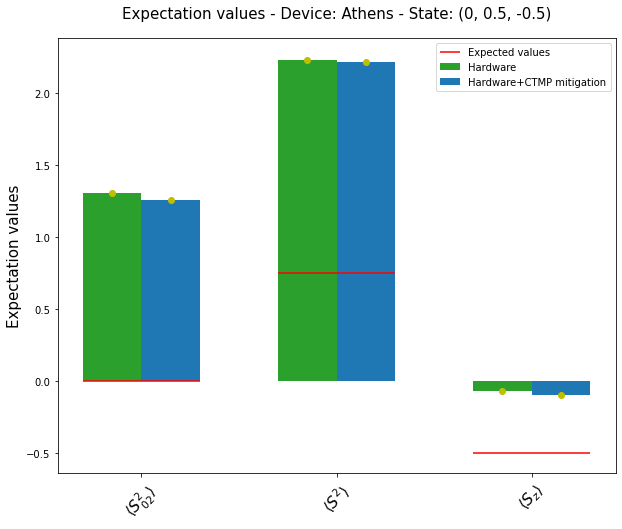

In [130]:
# The histograms - Plot of expectation values
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.3

data=[]
err_data=[]
for el in res_raw:
    data.append(el[0])
    err_data.append(el[1])

rects1 = ax.bar(x_lab - width/2, data, width, label='Hardware',color='tab:green')
ax.errorbar(x_lab - width/2,data,yerr=err_data,fmt='o',color='y')

data=[]
err_data=[]
for el in res_CTMP:
    data.append(el[0])
    err_data.append(el[1])

rects2 = ax.bar(x_lab + width/2, data, width, label='Hardware+CTMP mitigation',color='tab:blue')
ax.errorbar(x_lab + width/2,data,yerr=err_data,fmt='o',color='y')


ax.hlines(y=l[0]*(l[0]+1), xmin=0-width, xmax=0+width,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-width, xmax=1+width,colors="r")
ax.hlines(y=l[2], xmin=2-width, xmax=2+width,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_{02}^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()

**Observation** Is the problem connected with the `expectation_value` method or with the transpilation of the unitary matrix $U$ which diagonalizes the given operator $O$?

## Tensored mitigation

In [11]:
e5,U5 = [],[]
e5.append(LA.eigh(op_s022_5.to_matrix())[0])
U5.append(LA.eigh(op_s022_5.to_matrix())[1])
e5.append(LA.eigh(op_s2_5.to_matrix())[0])
U5.append(LA.eigh(op_s2_5.to_matrix())[1])
e5.append(LA.eigh(op_sz_5.to_matrix())[0])
U5.append(LA.eigh(op_sz_5.to_matrix())[1])

### Method A

First we create the mitigator fitter function.

In [14]:
# READOUT ERROR MITIGATION with flag: measurement_error_mitigation_cls = CompleteMeasFitter
instance = QuantumInstance(backend                          = device,
                           shots                            = 8192,
                           coupling_map                     = device.configuration().coupling_map,
                           optimization_level               = 3,
                           initial_layout                   = [0,1,2,3,4])

# Generate calibration circuits
cal_circs, metadata = mit.expval_meas_mitigator_circuits(5, method='tensored')
result = instance.execute(cal_circs)
# Fit mitigator
mitigator = mit.ExpvalMeasMitigatorFitter(result,metadata).fit()

# Plot fitted N-qubit assignment matrix
#mitigator.plot_assignment_matrix()

Now we use the mitigator fitter on the selected circuit. We use the device: `ibmq_athens`.

In [15]:
res_raw,res_tensored = [],[]

for i in range(3):
    l = lab_list[0]
    circ = QuantumCircuit(5)

    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

    circ.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        # Alternative way to create a controlled-Hadamard
        #c_gate = HGate().control(1)
        #circ.append(c_gate,[1,0])
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]+0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]+0.5==-1:
            circ.cx(1,0)

    circ.x(1)

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]-0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]-0.5==-1:
            circ.cx(1,0)

    circ.x(1)
    circ.cx(0,2)
    #print("Circuit associated with (0,1/2,-1/2)")
    #print(circ.draw())

    circ.unitary(U5[i],[0,1,2,3,4])
    circ.measure_all()
    if i==0:
        print(circ.draw())
    
    instance = QuantumInstance(backend                          = device,
                               shots                            = 8192,
                               coupling_map                     = device.configuration().coupling_map,
                               optimization_level               = 3,
                               initial_layout                   = [0,1,2,3,4])

    
    #instance = QuantumInstance(backend = Aer.get_backend("statevector_simulator")) 

    # Execute
    result = instance.execute(circ)
    counts = result.get_counts(0)

    # Expectation value of operators without mitigation
    res_raw.append(mit.expectation_value(counts,diagonal=e5[i]))
    
    # Expectation value of operators with mitigation
    res_tensored.append(mit.expectation_value(counts,diagonal=e5[i],meas_mitigator=mitigator))

                 ┌───┐┌───┐          ┌───┐┌───┐               ┌──────────┐ ░ »
   q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──┤0         ├─░─»
        ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  │          │ ░ »
   q_1: ┤ RY(π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──┤1         ├─░─»
        └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐│          │ ░ »
   q_2: ───────────────────┤ X ├───────────────┤ X ├─────┤ X ├┤2 unitary ├─░─»
                           └───┘               └───┘     └───┘│          │ ░ »
   q_3: ──────────────────────────────────────────────────────┤3         ├─░─»
                                                              │          │ ░ »
   q_4: ──────────────────────────────────────────────────────┤4         ├─░─»
                                                              └──────────┘ ░ »
meas: 5/═════════════════════════════════════════════════════════════════════»
                                                    

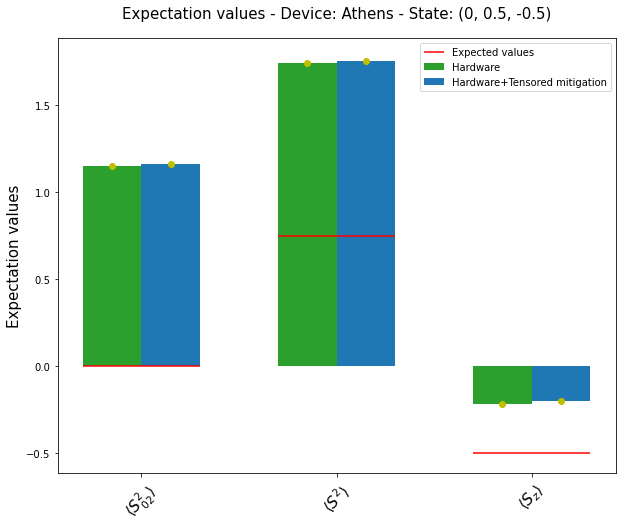

In [16]:
# The histograms - Plot of expectation values
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.3

data=[]
err_data=[]
for el in res_raw:
    data.append(el[0])
    err_data.append(el[1])

rects1 = ax.bar(x_lab - width/2, data, width, label='Hardware',color='tab:green')
ax.errorbar(x_lab - width/2,data,yerr=err_data,fmt='o',color='y')

data=[]
err_data=[]
for el in res_tensored:
    data.append(el[0])
    err_data.append(el[1])

rects2 = ax.bar(x_lab + width/2, data, width, label='Hardware+Tensored mitigation',color='tab:blue')
ax.errorbar(x_lab + width/2,data,yerr=err_data,fmt='o',color='y')


ax.hlines(y=l[0]*(l[0]+1), xmin=0-width, xmax=0+width,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-width, xmax=1+width,colors="r")
ax.hlines(y=l[2], xmin=2-width, xmax=2+width,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_{02}^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()

### Method B

The difference w.r.t. the method above is that the spin operators measurement is made using the mitigated counts. Again we have to use the unitary matrix $U$ which diagonalizes the corresponding spin operator.

In [21]:
res_raw, res_mitigated = [], []

for i in range(3):
    ###########################
    # Definition of the circuit
    ###########################
    
    l = lab_list[0]
    circ = QuantumCircuit(5)

    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

    circ.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        # Alternative way to create a controlled-Hadamard
        #c_gate = HGate().control(1)
        #circ.append(c_gate,[1,0])
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]+0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]+0.5==-1:
            circ.cx(1,0)

    circ.x(1)

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]-0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]-0.5==-1:
            circ.cx(1,0)

    circ.x(1)
    circ.cx(0,2)
    
    circ.unitary(U5[i],[0,1,2,3,4])     # <---- Here the difference when the counter i changes
    circ.measure_all()
    
    if i==0:
        print(circ.draw())

    ####################
    # Instance Execution
    ####################

    # Definition of the instance
    instance = QuantumInstance(backend                          = device,
                               shots                            = 8192,
                               coupling_map                     = device.configuration().coupling_map,
                               optimization_level               = 3,
                               initial_layout                   = [0,1,2,3,4])
    
    # Calibration circuits execution
    mit_pattern = [[0,1,2],[3,4]]
    meas_calibs, state_labels = mit.tensored_meas_cal(mit_pattern=mit_pattern, qr=QuantumRegister(5), circlabel='mcal')
    print("Calibration job pending",end=" ")
    cal_results = instance.execute(meas_calibs)
    print("Calibration job completed")
    meas_fitter = mit.TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

    # Circuits execution
    print("Job pending",end=" ")
    results = instance.execute(circ)
    print("Job completed")

    #####################
    # Analysis of results
    #####################

    # Results without mitigation
    counts = results.get_counts(0)
    
    # Use the following lines to get the MITIGATED COUNTS
    # We could use the mitigated counts to calculate the expectation value without the use of the meas_mitigator flag

    # Get the filter object
    meas_filter = meas_fitter.filter
    # Results with mitigation
    mitigated_results = meas_filter.apply(results)
    mitigated_counts  = mitigated_results.get_counts(0)
    
    # Plot of counts vs mitigated counts
    #plot_histogram([raw_counts, mitigated_counts], title="Counts",legend=['Raw', 'Mitigated'])
    
    # Expectation value of operators without mitigation
    res_raw.append(mit.expectation_value(counts,diagonal=e5[i]))
    
    # Expectation value of operators with mitigation
    res_mitigated.append(mit.expectation_value(mitigated_counts,diagonal=e5[i]))
    

                 ┌───┐┌───┐          ┌───┐┌───┐               ┌──────────┐ ░ »
   q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──┤0         ├─░─»
        ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  │          │ ░ »
   q_1: ┤ RY(π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──┤1         ├─░─»
        └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐│          │ ░ »
   q_2: ───────────────────┤ X ├───────────────┤ X ├─────┤ X ├┤2 unitary ├─░─»
                           └───┘               └───┘     └───┘│          │ ░ »
   q_3: ──────────────────────────────────────────────────────┤3         ├─░─»
                                                              │          │ ░ »
   q_4: ──────────────────────────────────────────────────────┤4         ├─░─»
                                                              └──────────┘ ░ »
meas: 5/═════════════════════════════════════════════════════════════════════»
                                                    

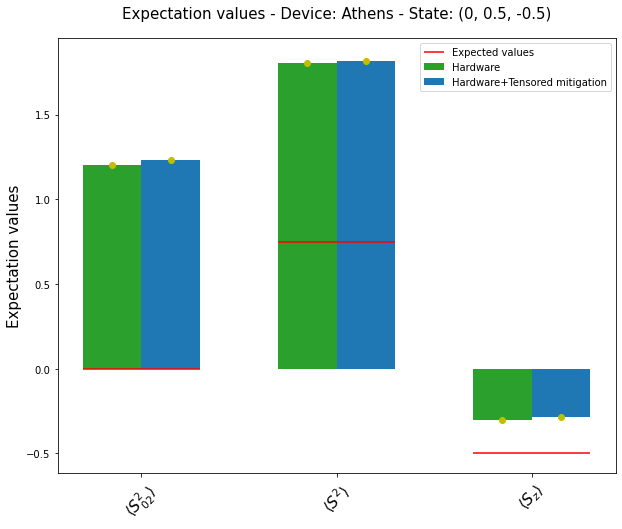

In [22]:
# The histograms - Plot of expectation values
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.3

data=[]
err_data=[]
for el in res_raw:
    data.append(el[0])
    err_data.append(el[1])

rects1 = ax.bar(x_lab - width/2, data, width, label='Hardware',color='tab:green')
ax.errorbar(x_lab - width/2,data,yerr=err_data,fmt='o',color='y')

data=[]
err_data=[]
for el in res_mitigated:
    data.append(el[0])
    err_data.append(el[1])

rects2 = ax.bar(x_lab + width/2, data, width, label='Hardware+Tensored mitigation',color='tab:blue')
ax.errorbar(x_lab + width/2,data,yerr=err_data,fmt='o',color='y')


ax.hlines(y=l[0]*(l[0]+1), xmin=0-width, xmax=0+width,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-width, xmax=1+width,colors="r")
ax.hlines(y=l[2], xmin=2-width, xmax=2+width,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_{02}^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()

### `reset` option of last two qubits - State tomography of $|s_L=0,s = 1/2, s_z = -1/2 \rangle$ circuit on the $5$-qubit register

In [43]:
s = 8192
l = lab_list[0]
    
################################
# Definition of the circuit
################################

circ    = QuantumCircuit(5)

# theta gives the angle to use in the Ry Gate
theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

circ.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

if l[0]==0:
    circ.cx(1,0)
    circ.ch(1,0)
    # Alternative way to create a controlled-Hadamard
    #c_gate = HGate().control(1)
    #circ.append(c_gate,[1,0])
    circ.cx(1,2)

elif l[0]==1:
    if l[2]+0.5==0:
        circ.ch(1,0)
        circ.cx(1,2)
    elif l[2]+0.5==-1:
        circ.cx(1,0)

circ.x(1)

if l[0]==0:
    circ.cx(1,0)
    circ.ch(1,0)
    circ.cx(1,2)

elif l[0]==1:
    if l[2]-0.5==0:
        circ.ch(1,0)
        circ.cx(1,2)
    elif l[2]-0.5==-1:
        circ.cx(1,0)

circ.x(1)
circ.cx(0,2)
circ.reset([3]*5)     # <------ Here!
circ.reset([4]*5)


# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

print("Circuit associated with state ",lab_list[0]," on 5 qubits")
print(circ.draw())

################################
# Analysis of the first 3 qubits
################################

backend = Aer.get_backend("qasm_simulator")

print("Analysis of the first 3 qubits")
# Target state
target_state = qiskit.quantum_info.Statevector.from_instruction(circ3)

# Generate circuits and run on simulator
t = time.time()

# Generate the state tomography circuit
tomo_circ = state_tomography_circuits(circ,[0,1,2])

# Execute
job = qiskit.execute(tomo_circ, device, shots=8192)
print('Time taken:', time.time() - t)

# Fit result
tomo_fitter = StateTomographyFitter(job.result(), tomo_circ)

# NO CORRECTION
# Perform the tomography fit which outputs a density matrix
rho_fit = tomo_fitter.fit(method='lstsq')
fid  = qiskit.quantum_info.state_fidelity(rho_fit, target_state)
print('State Fidelity (no correction): F = {:.5f}'.format(fid))

# Generate the calibration circuits (Readout Error Mitigation)
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1,2])

job_cal = qiskit.execute(meas_calibs, device, shots=8192)
meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

# WITH CORRECTION
correct_tomo_results = meas_fitter.filter.apply(job.result(), method='least_squares')
tomo_mit = StateTomographyFitter(correct_tomo_results, tomo_circ)
rho_fit_mit = tomo_mit.fit(method='lstsq')
fid_mit = qiskit.quantum_info.state_fidelity(rho_fit_mit, target_state)
print('State fidelity (w/ correction): F = {:.5f}'.format(fid_mit))

################################
# Analysis of the last 2 qubits
################################

print("\n")
print("Analysis of the last 2 qubits")
# Target state
qc = QuantumCircuit(2)
target_state2 = qiskit.quantum_info.Statevector.from_instruction(qc)
#print(target_state2)

# Generate circuits and run on simulator
t2 = time.time()

# Generate the state tomography circuit
tomo_circ2 = state_tomography_circuits(circ,[3,4])

# Execute
job2 = qiskit.execute(tomo_circ2, device, shots=8192)
print('Time taken:', time.time() - t2)

# Fit result
tomo_fitter2 = StateTomographyFitter(job2.result(), tomo_circ2)

# NO CORRECTION
# Perform the tomography fit which outputs a density matrix
rho_fit2 = tomo_fitter2.fit(method='lstsq')
fid2  = qiskit.quantum_info.state_fidelity(rho_fit2, target_state2)
print('State Fidelity (no correction): F = {:.5f}'.format(fid2))

# Generate the calibration circuits (Readout Error Mitigation)
meas_calibs2, state_labels2 = mc.complete_meas_cal(qubit_list=[3,4])

job_cal2 = qiskit.execute(meas_calibs2, device, shots=8192)
meas_fitter2 = mc.CompleteMeasFitter(job_cal.result(),state_labels2)

# WITH CORRECTION
correct_tomo_results2 = meas_fitter2.filter.apply(job2.result(), method='least_squares')
tomo_mit2 = StateTomographyFitter(correct_tomo_results2, tomo_circ2)
rho_fit_mit2 = tomo_mit2.fit(method='lstsq')
fid_mit2 = qiskit.quantum_info.state_fidelity(rho_fit_mit2, target_state2)
print('State fidelity (w/ correction): F = {:.5f}'.format(fid_mit2))

Circuit associated with  (0, 0.5, -0.5)
              ┌───┐┌───┐          ┌───┐┌───┐               
q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──
     ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  
q_1: ┤ RY(π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──
     └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐
q_2: ───────────────────┤ X ├───────────────┤ X ├─────┤ X ├
                        └───┘               └───┘     └───┘
q_3: ───|0>────|0>──|0>──|0>──|0>──────────────────────────
                                                           
q_4: ───|0>────|0>──|0>──|0>──|0>──────────────────────────
                                                           


By looking at the fidelities of $\rho_{012}$ we see results similar to those obtained without `reset` option, so we conclude that resetting the qubits is not useful as we expected. 